<center><h2>Extend MP-NeRF by computing distributions</h2></center>

In [1]:
# !mkdir plots
import time
# science
import numpy as np
import matplotlib.pyplot as plt
# ML
import torch
from einops import repeat, rearrange

In [2]:
from tqdm import tqdm
import joblib
import sidechainnet

In [3]:
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

### Load a protein in SCN format - you can skip this since a joblib file is provided

In [4]:
dataloaders = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
# ProteinDataset(casp_version=12, split='train', n_proteins=81454,
#               created='Sep 20, 2020')

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


dict_keys(['train', 'train-eval', 'test', 'valid-10', 'valid-20', 'valid-30', 'valid-40', 'valid-50', 'valid-70', 'valid-90'])

In [5]:
def get_prot(min_len=80, max_len=150, verbose=0):
    """ Gets a protein from sidechainnet and returns the right attrs for training. """
    for batch in dataloaders['train']:
        real_seqs = [''.join([VOCAB.int2char(aa) for aa in seq]) for seq in batch.int_seqs.numpy()]
        # print(len(real_seqs[0]))
        try:
            for i in range(len(batch.int_seqs.numpy())):
                # get variables
                seq     = real_seqs[i]
                int_seq = batch.int_seqs[i]
                angles  = batch.angs[i]
                # get padding
                padding_angles = (torch.abs(angles).sum(dim=-1) == 0).long().sum()
                padding_seq    = (np.array([x for x in seq]) == "_").sum()
                # only accept sequences with right dimensions and no missing coords
                # if padding_seq == padding_angles:
                # print("paddings_match")
                # print("len coords", list(batch.crds[i].shape)[0]//3, "vs int_seq", len(int_seq))
                if list(batch.crds[i].shape)[0]//14 == len(int_seq):
                    if max_len > len(seq) and len(seq) > min_len and padding_seq == padding_angles:
                        if verbose:
                            print("stopping at sequence of length", len(seq))
                        # print(len(seq), angles.shape, padding_seq == padding_angles == list(batch.crds[i].shape)[0]//3)
                        # print("paddings: ", padding_seq, padding_angles)
                        raise StopIteration
                    else:
                        # print("found a seq of length:", len(seq), "but below the threshold:", min_len)
                        pass
        except StopIteration:
            break
            
    return seq, batch.crds[i], angles, padding_seq

In [18]:
prots_list = [get_prot(min_len=100, max_len=950) for i in tqdm(range(1000))]


  0%|          | 0/100 [03:26<?, ?it/s]0.56it/s]

  0%|          | 0/100 [03:27<?, ?it/s]7.11it/s]

  0%|          | 0/100 [03:27<?, ?it/s]5.57it/s]


  0%|          | 0/100 [03:27<?, ?it/s]

 30%|██▉       | 295/1000 [00:26<00:58, 12.10it/s]


 60%|█████▉    | 597/1000 [00:53<00:35, 11.47it/s]


 90%|████████▉ | 899/1000 [01:19<00:08, 11.95it/s]


100%|██████████| 1000/1000 [01:28<00:00, 11.32it/s][A


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load algos

In [20]:
import mp_nerf

In [21]:
prot_scaffolds = [mp_nerf.proteins.build_scaffolds_from_scn_angles(x[0][:-x[-1] or None],
                                                                   x[2][:-x[-1] or None].to(device)) for x in tqdm(prots_list)]

100%|██████████| 1000/1000 [00:16<00:00, 59.52it/s]


In [66]:
# build per-residue stats: 
AAS_WHOLE_INFO = {k: {atom: {"bond_lens": [], "bond_angs": [], "bond_dihedral": []} for atom in v["atom-names"]} \
                  for k,v in SC_BUILD_INFO.items()}

In [67]:
for i,prot in enumerate(prots_list): 
    seq = prot[0][:-prot[-1] or None]
    scaffolds = prot_scaffolds[i]
    scaffolds = {k:scaff.numpy() for k,scaff in scaffolds.items()}
    # for each aa, add info for its atoms
    for s,aa in enumerate(seq): 
        for n in range(4,14):
            if scaffolds["cloud_mask"][s][n] == True:
                atom = SC_BUILD_INFO[aa]["atom-names"][n-4]
                AAS_WHOLE_INFO[aa][atom]["bond_lens"].append( scaffolds["bond_mask"][s, n] )
                AAS_WHOLE_INFO[aa][atom]["bond_angs"].append( scaffolds["angles_mask"][0, s, n] )
                AAS_WHOLE_INFO[aa][atom]["bond_dihedral"].append( scaffolds["angles_mask"][-1, s, n])
            else:
                # no more atoms in this AA
                continue

In [68]:
AAS_WHOLE_INFO_NUMPY = {aa: {atom: {k:np.array(v) for k,v in v_aa[atom].items()} for atom in v_aa.keys()} 
                        for aa,v_aa in AAS_WHOLE_INFO.items()}

## Plot properties for each AA

In [148]:
KB_DICT = {AA: {atom: {k: np.nanmean(v) for k,v in v_atom.items()} 
                for atom,v_atom in v_AA.items()} 
           for AA,v_AA in AAS_WHOLE_INFO_NUMPY.items()} 

In [149]:
gaussian = lambda x,mu,sigma: 1/(sigma*(np.pi*np.sqrt(2))**0.5) * np.exp(-0.5*((x-mu)/sigma)**2)

### reform kb_dict

inverted mean needed in A in atom CB


<Figure size 432x288 with 0 Axes>

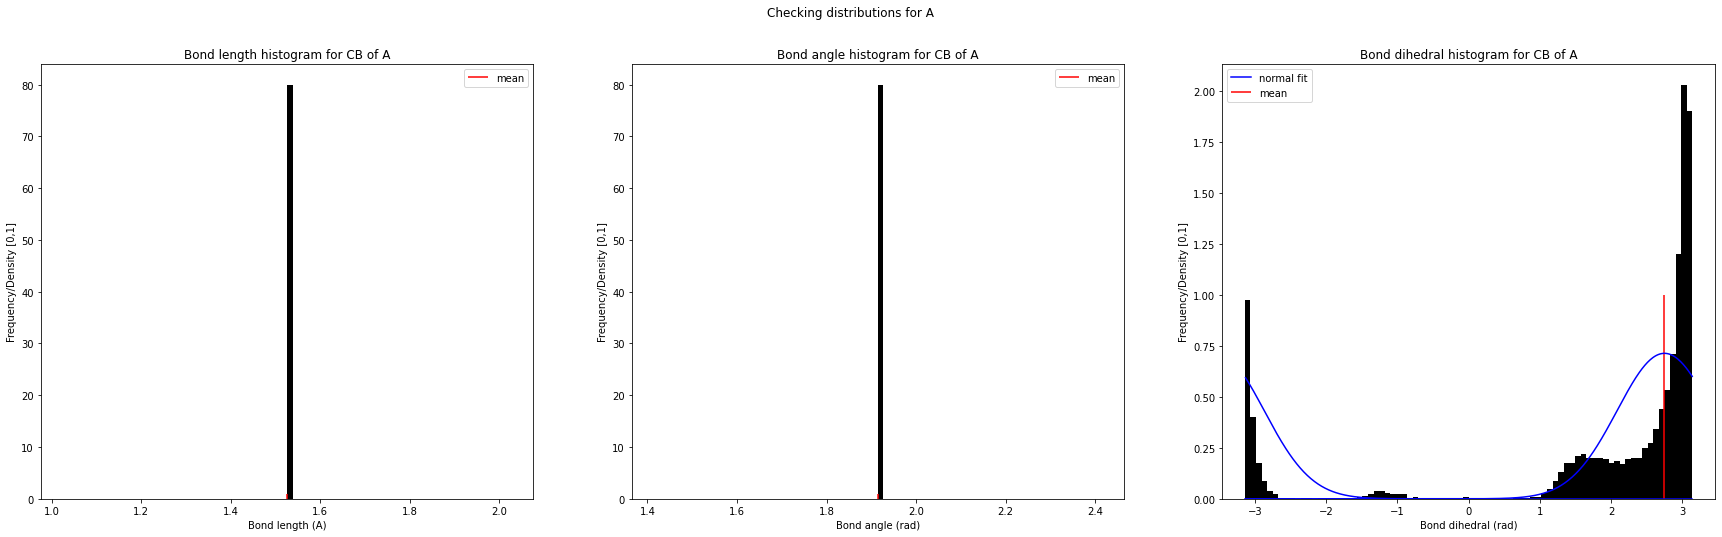

inverted mean needed in R in atom CB
inverted mean needed in R in atom CG
inverted mean needed in R in atom CD
inverted mean needed in R in atom NE
inverted mean needed in R in atom CZ


<Figure size 432x288 with 0 Axes>

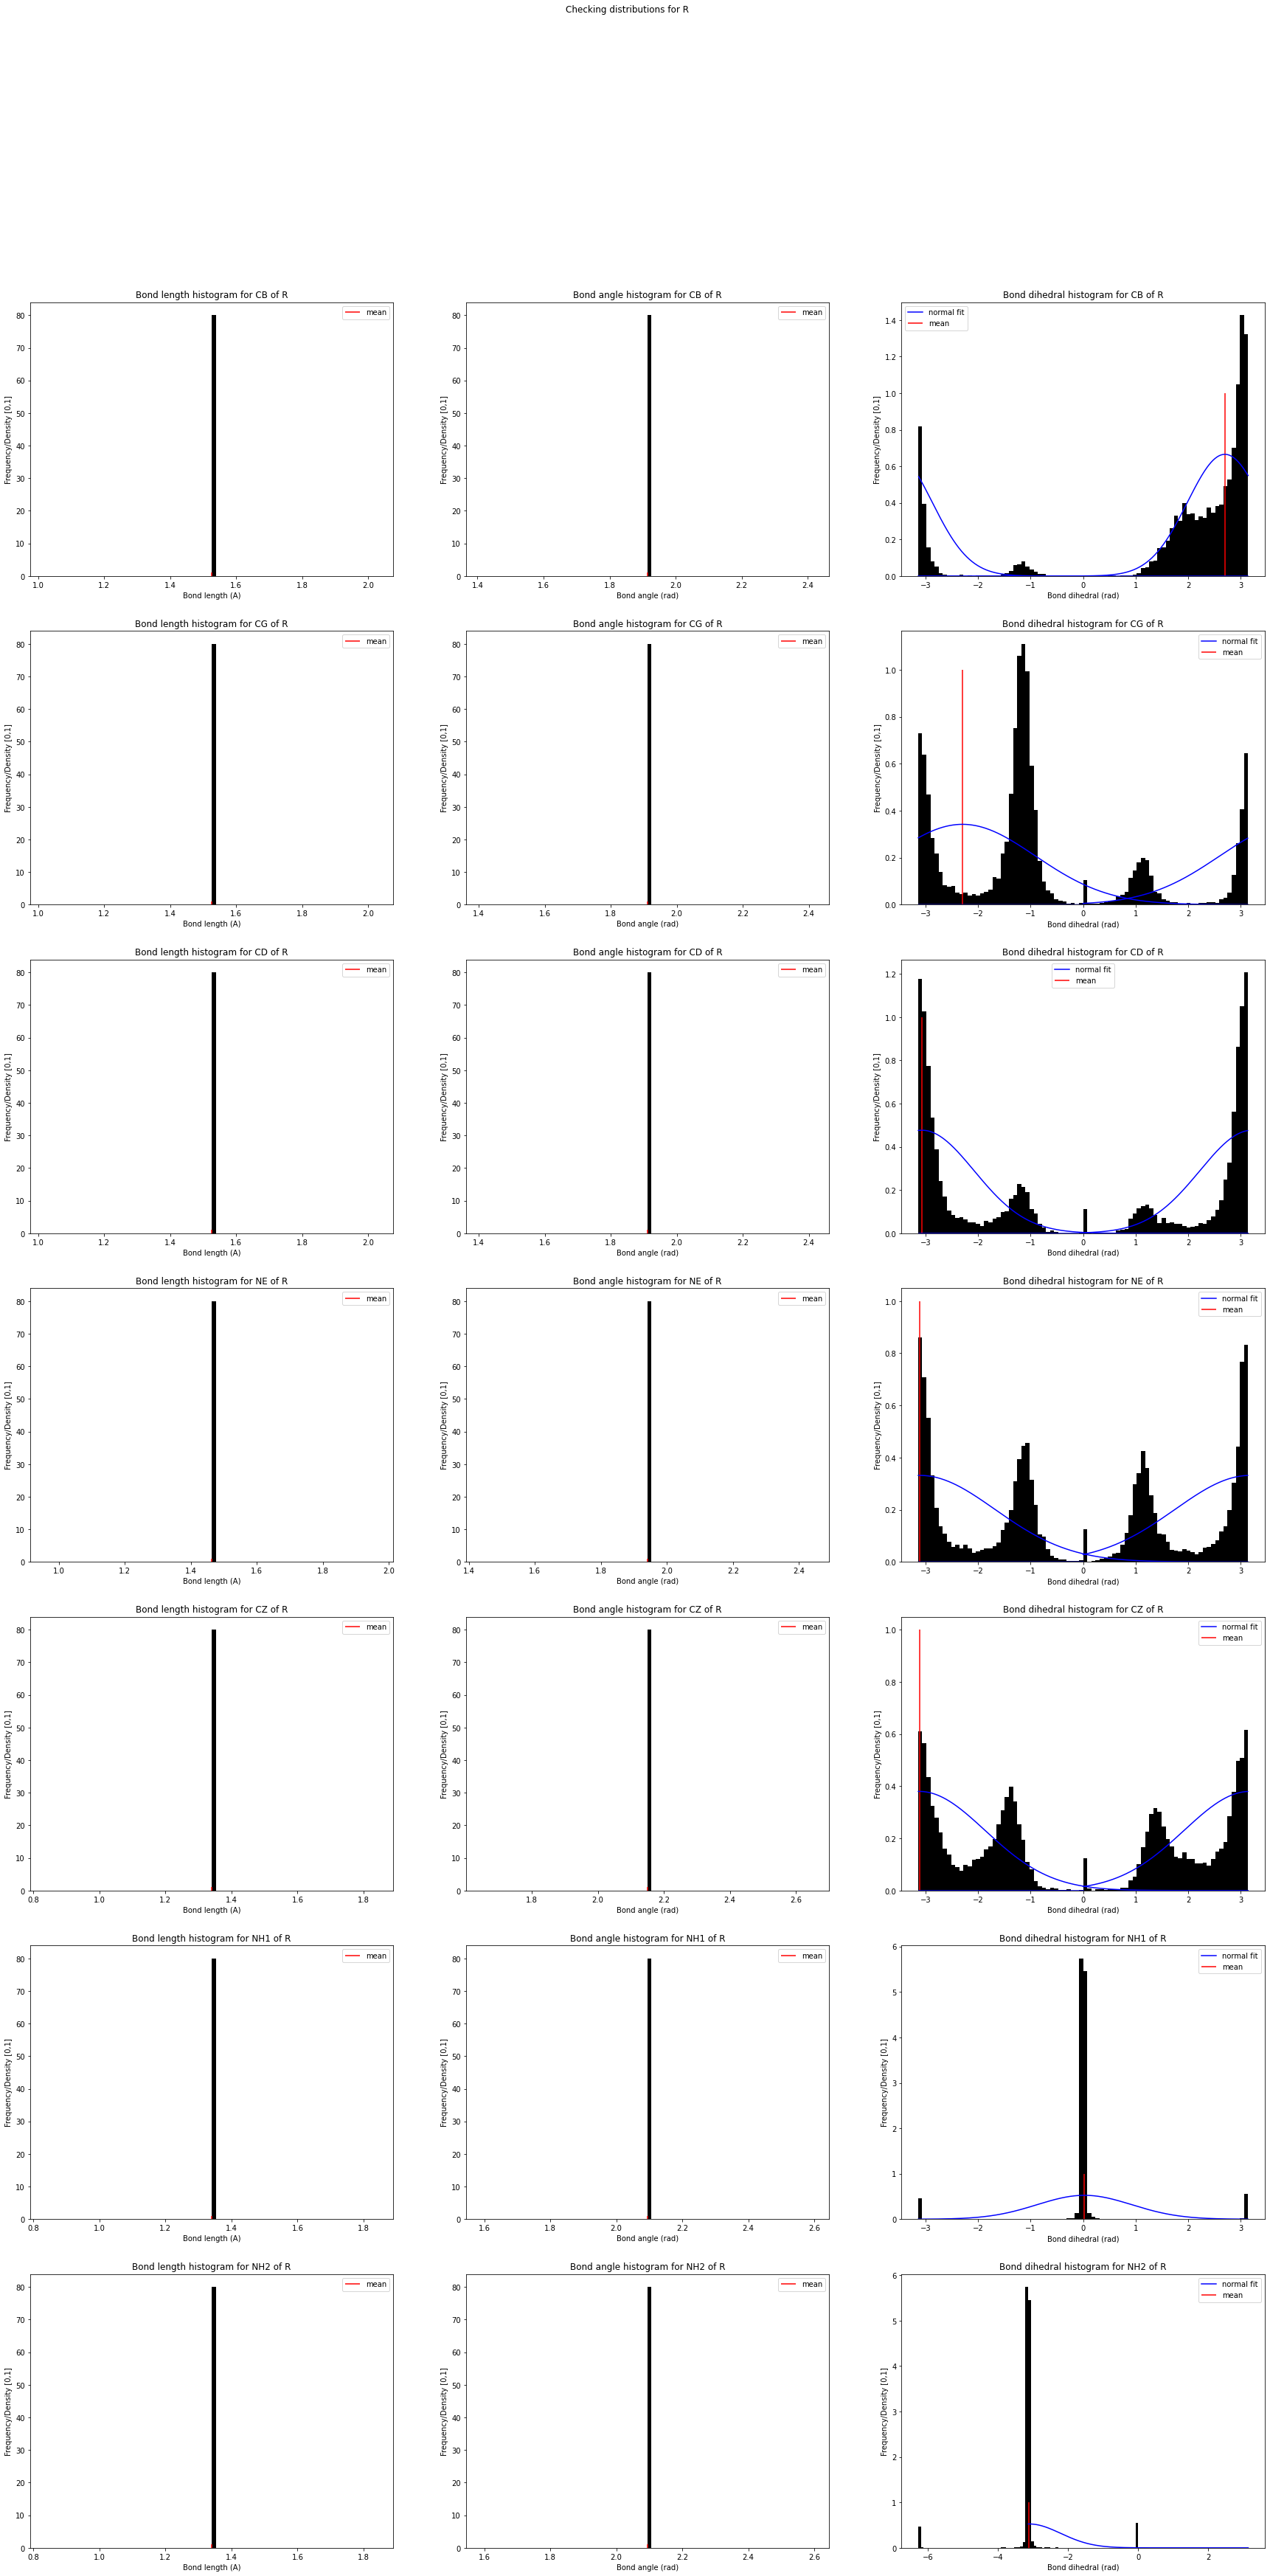

inverted mean needed in N in atom CB
inverted mean needed in N in atom CG


<Figure size 432x288 with 0 Axes>

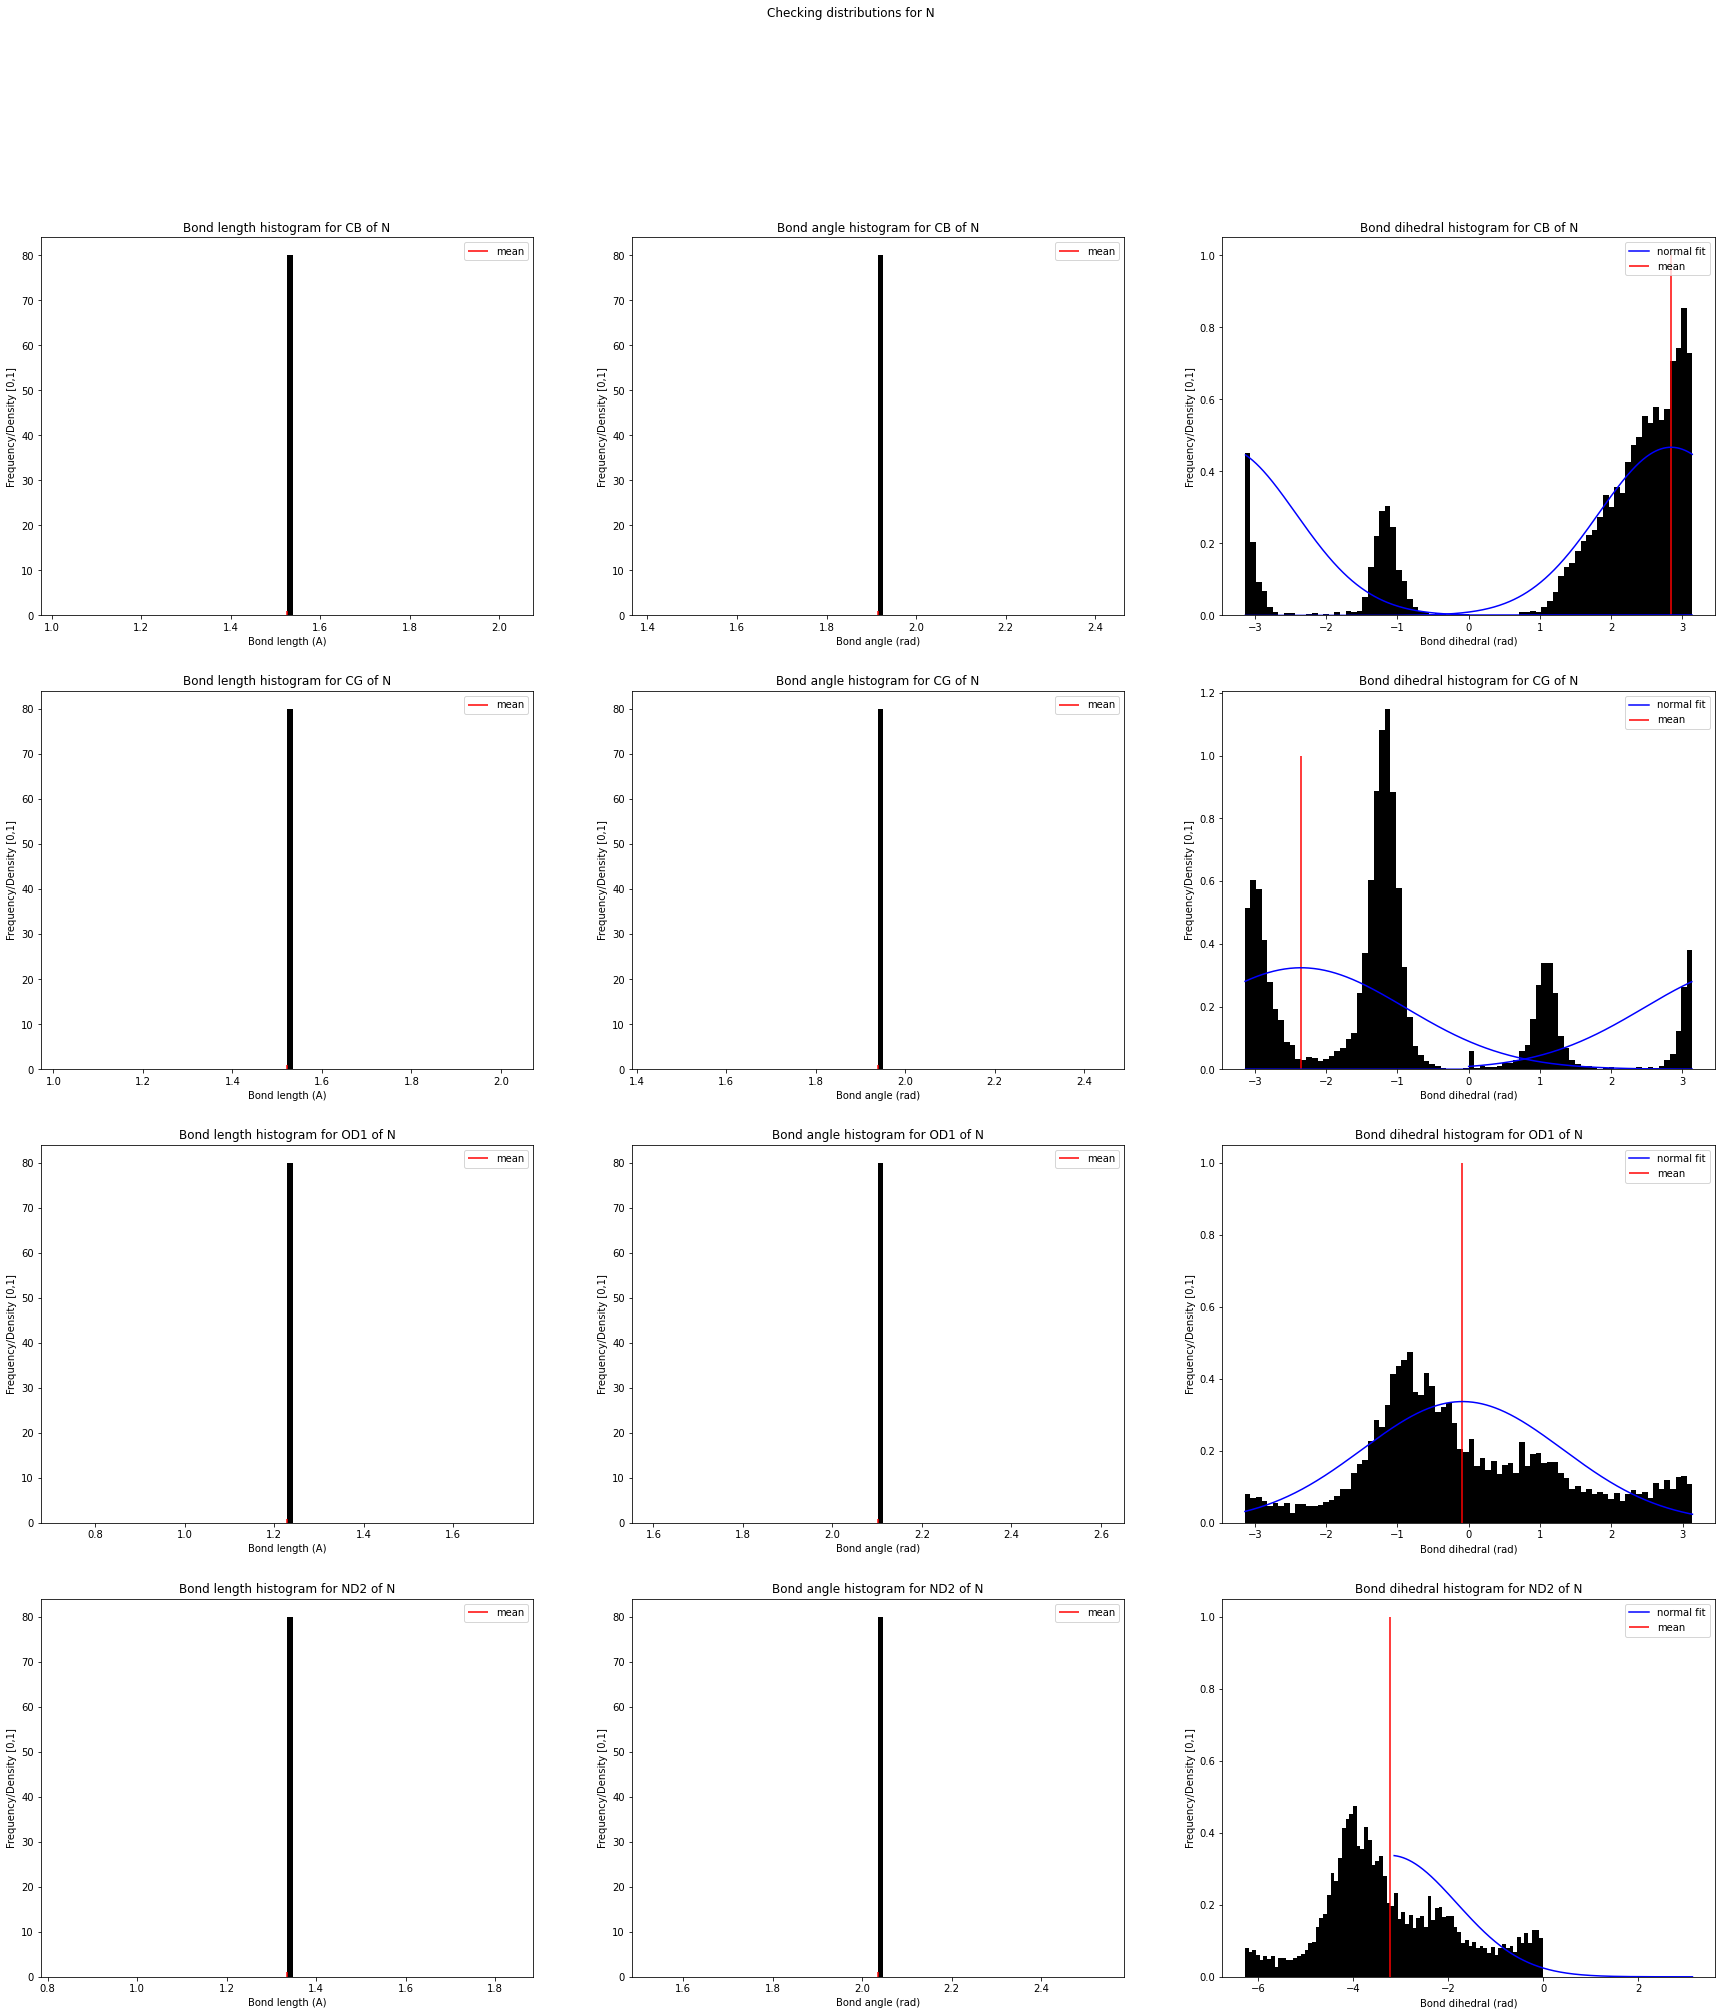

inverted mean needed in D in atom CB
inverted mean needed in D in atom CG


<Figure size 432x288 with 0 Axes>

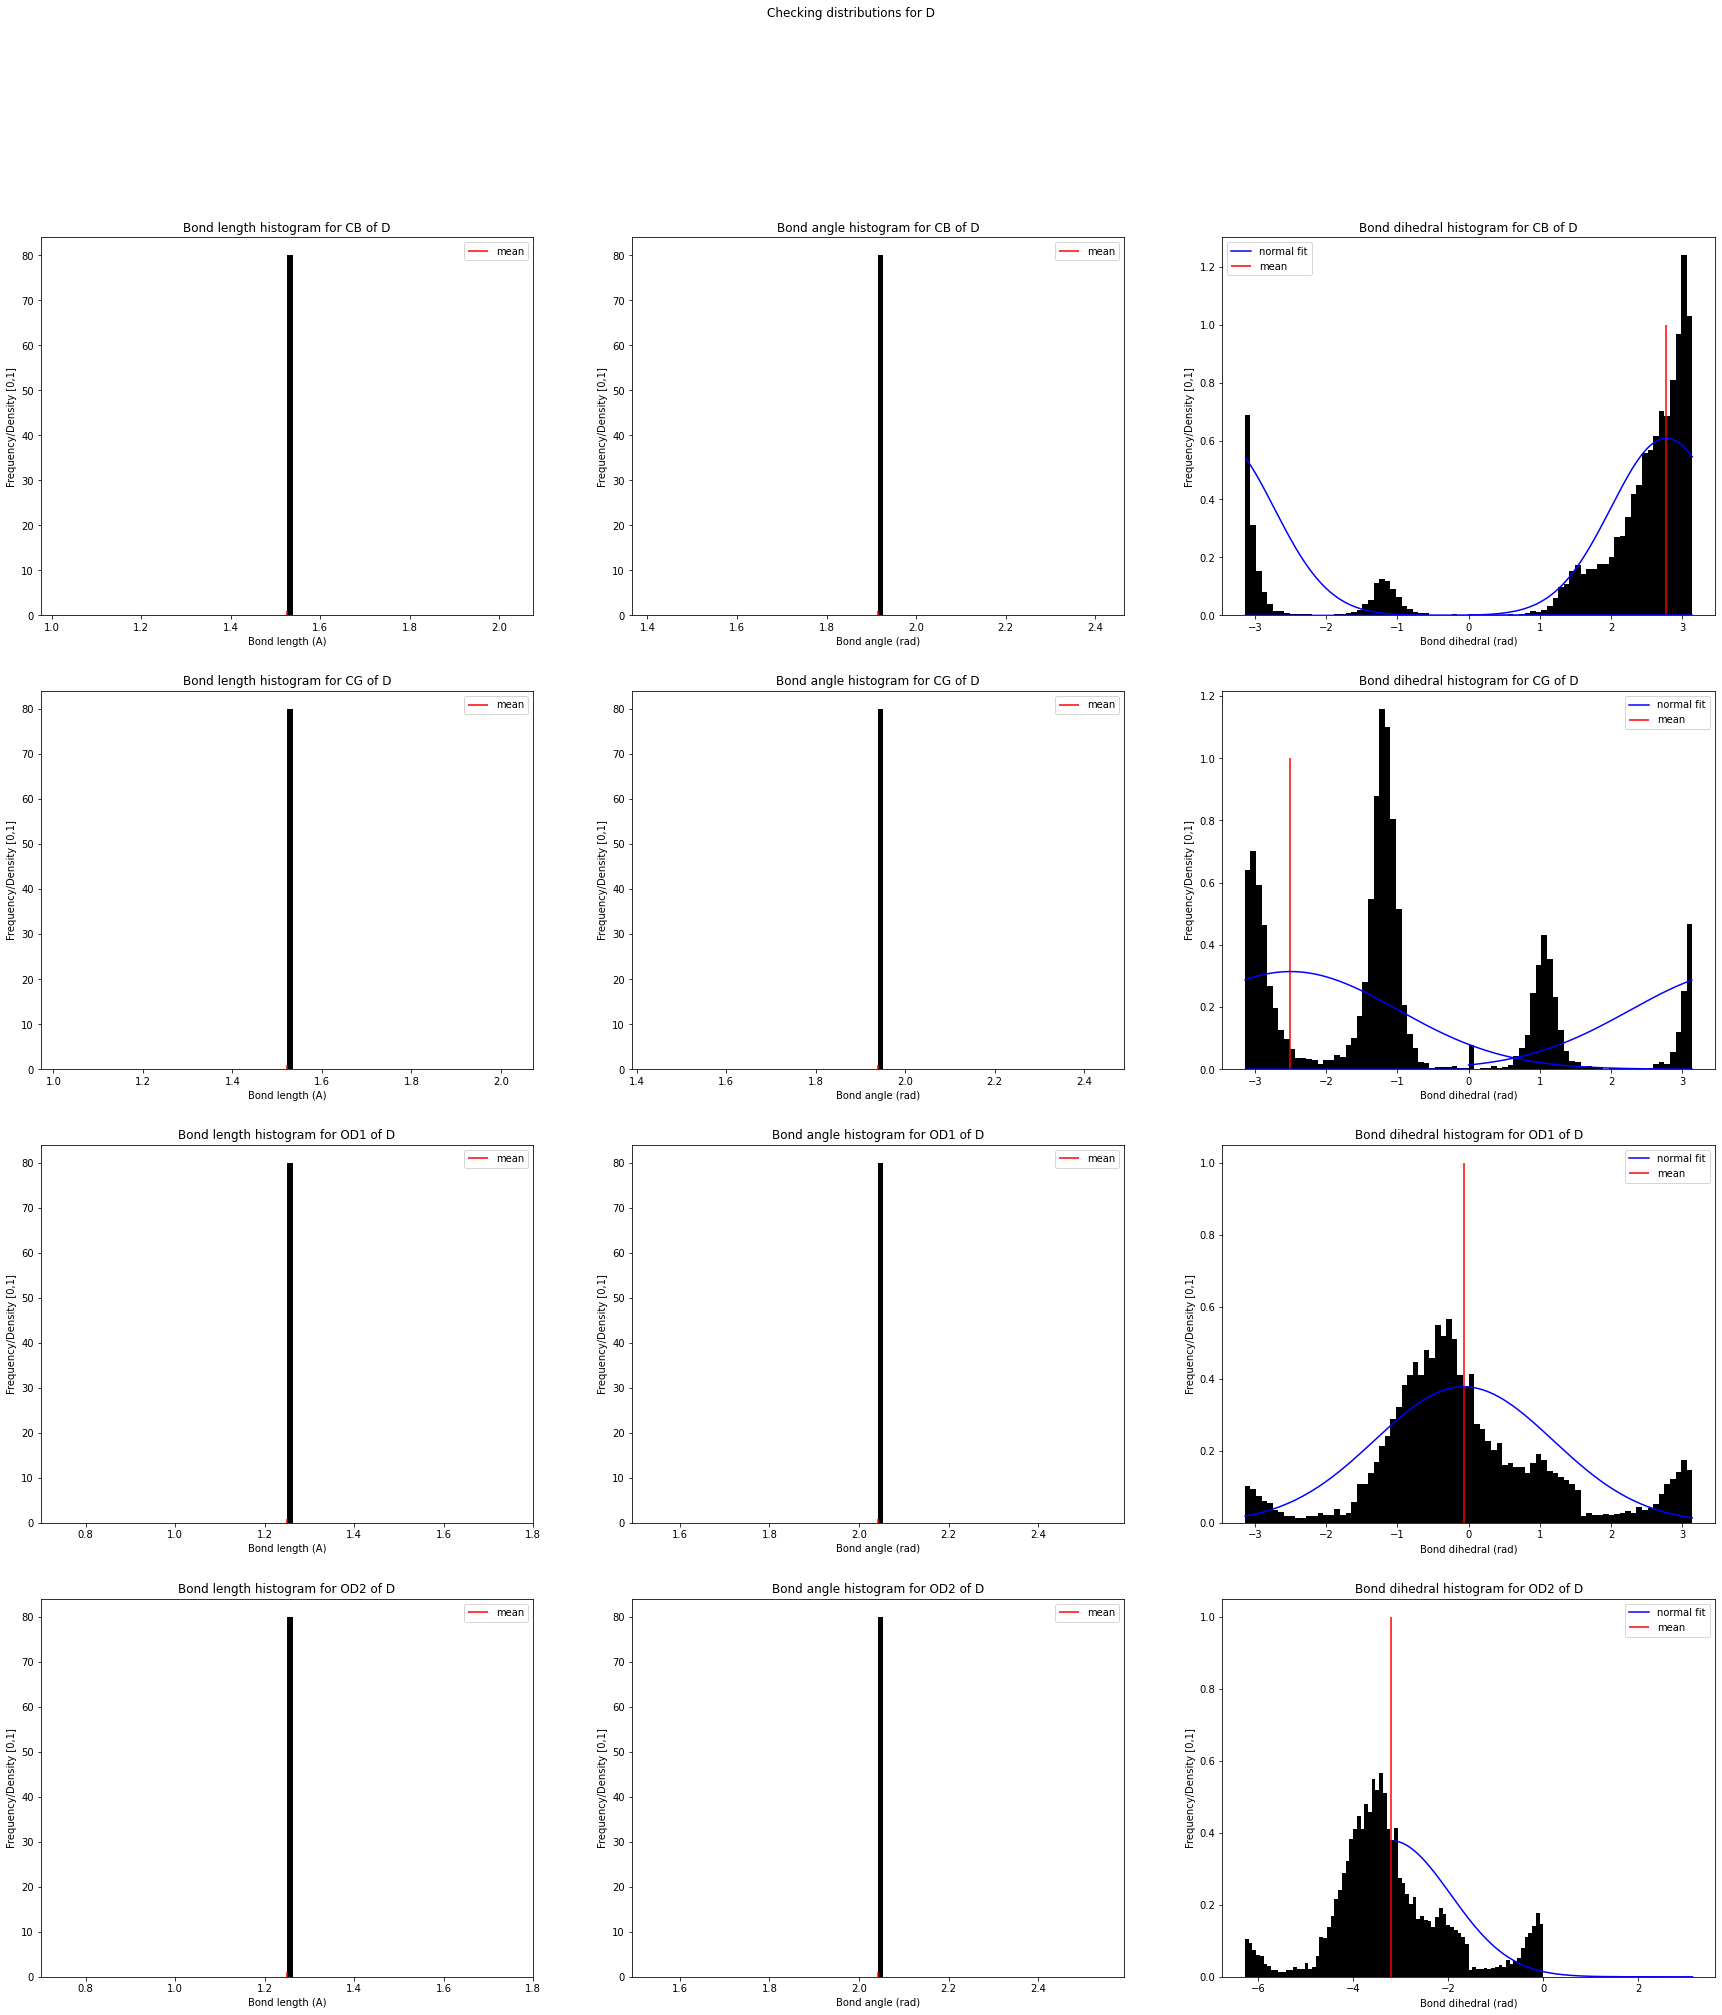

inverted mean needed in C in atom CB
inverted mean needed in C in atom SG


<Figure size 432x288 with 0 Axes>

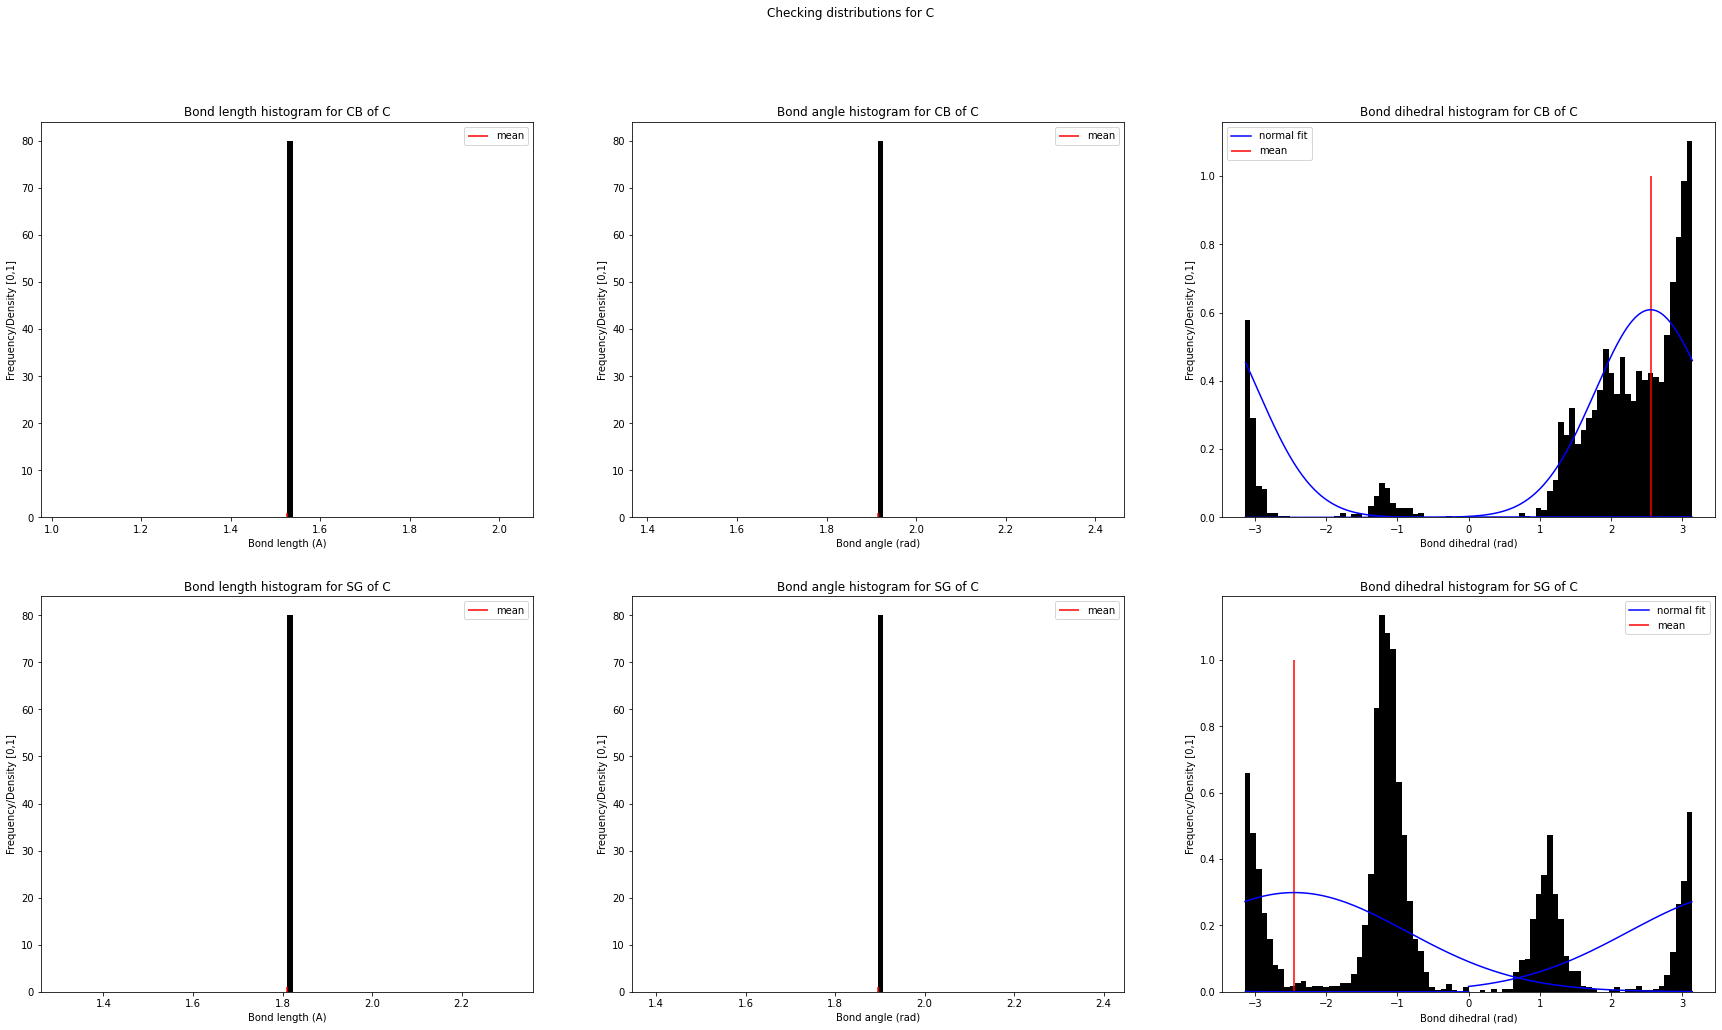

inverted mean needed in Q in atom CB
inverted mean needed in Q in atom CG
inverted mean needed in Q in atom CD


<Figure size 432x288 with 0 Axes>

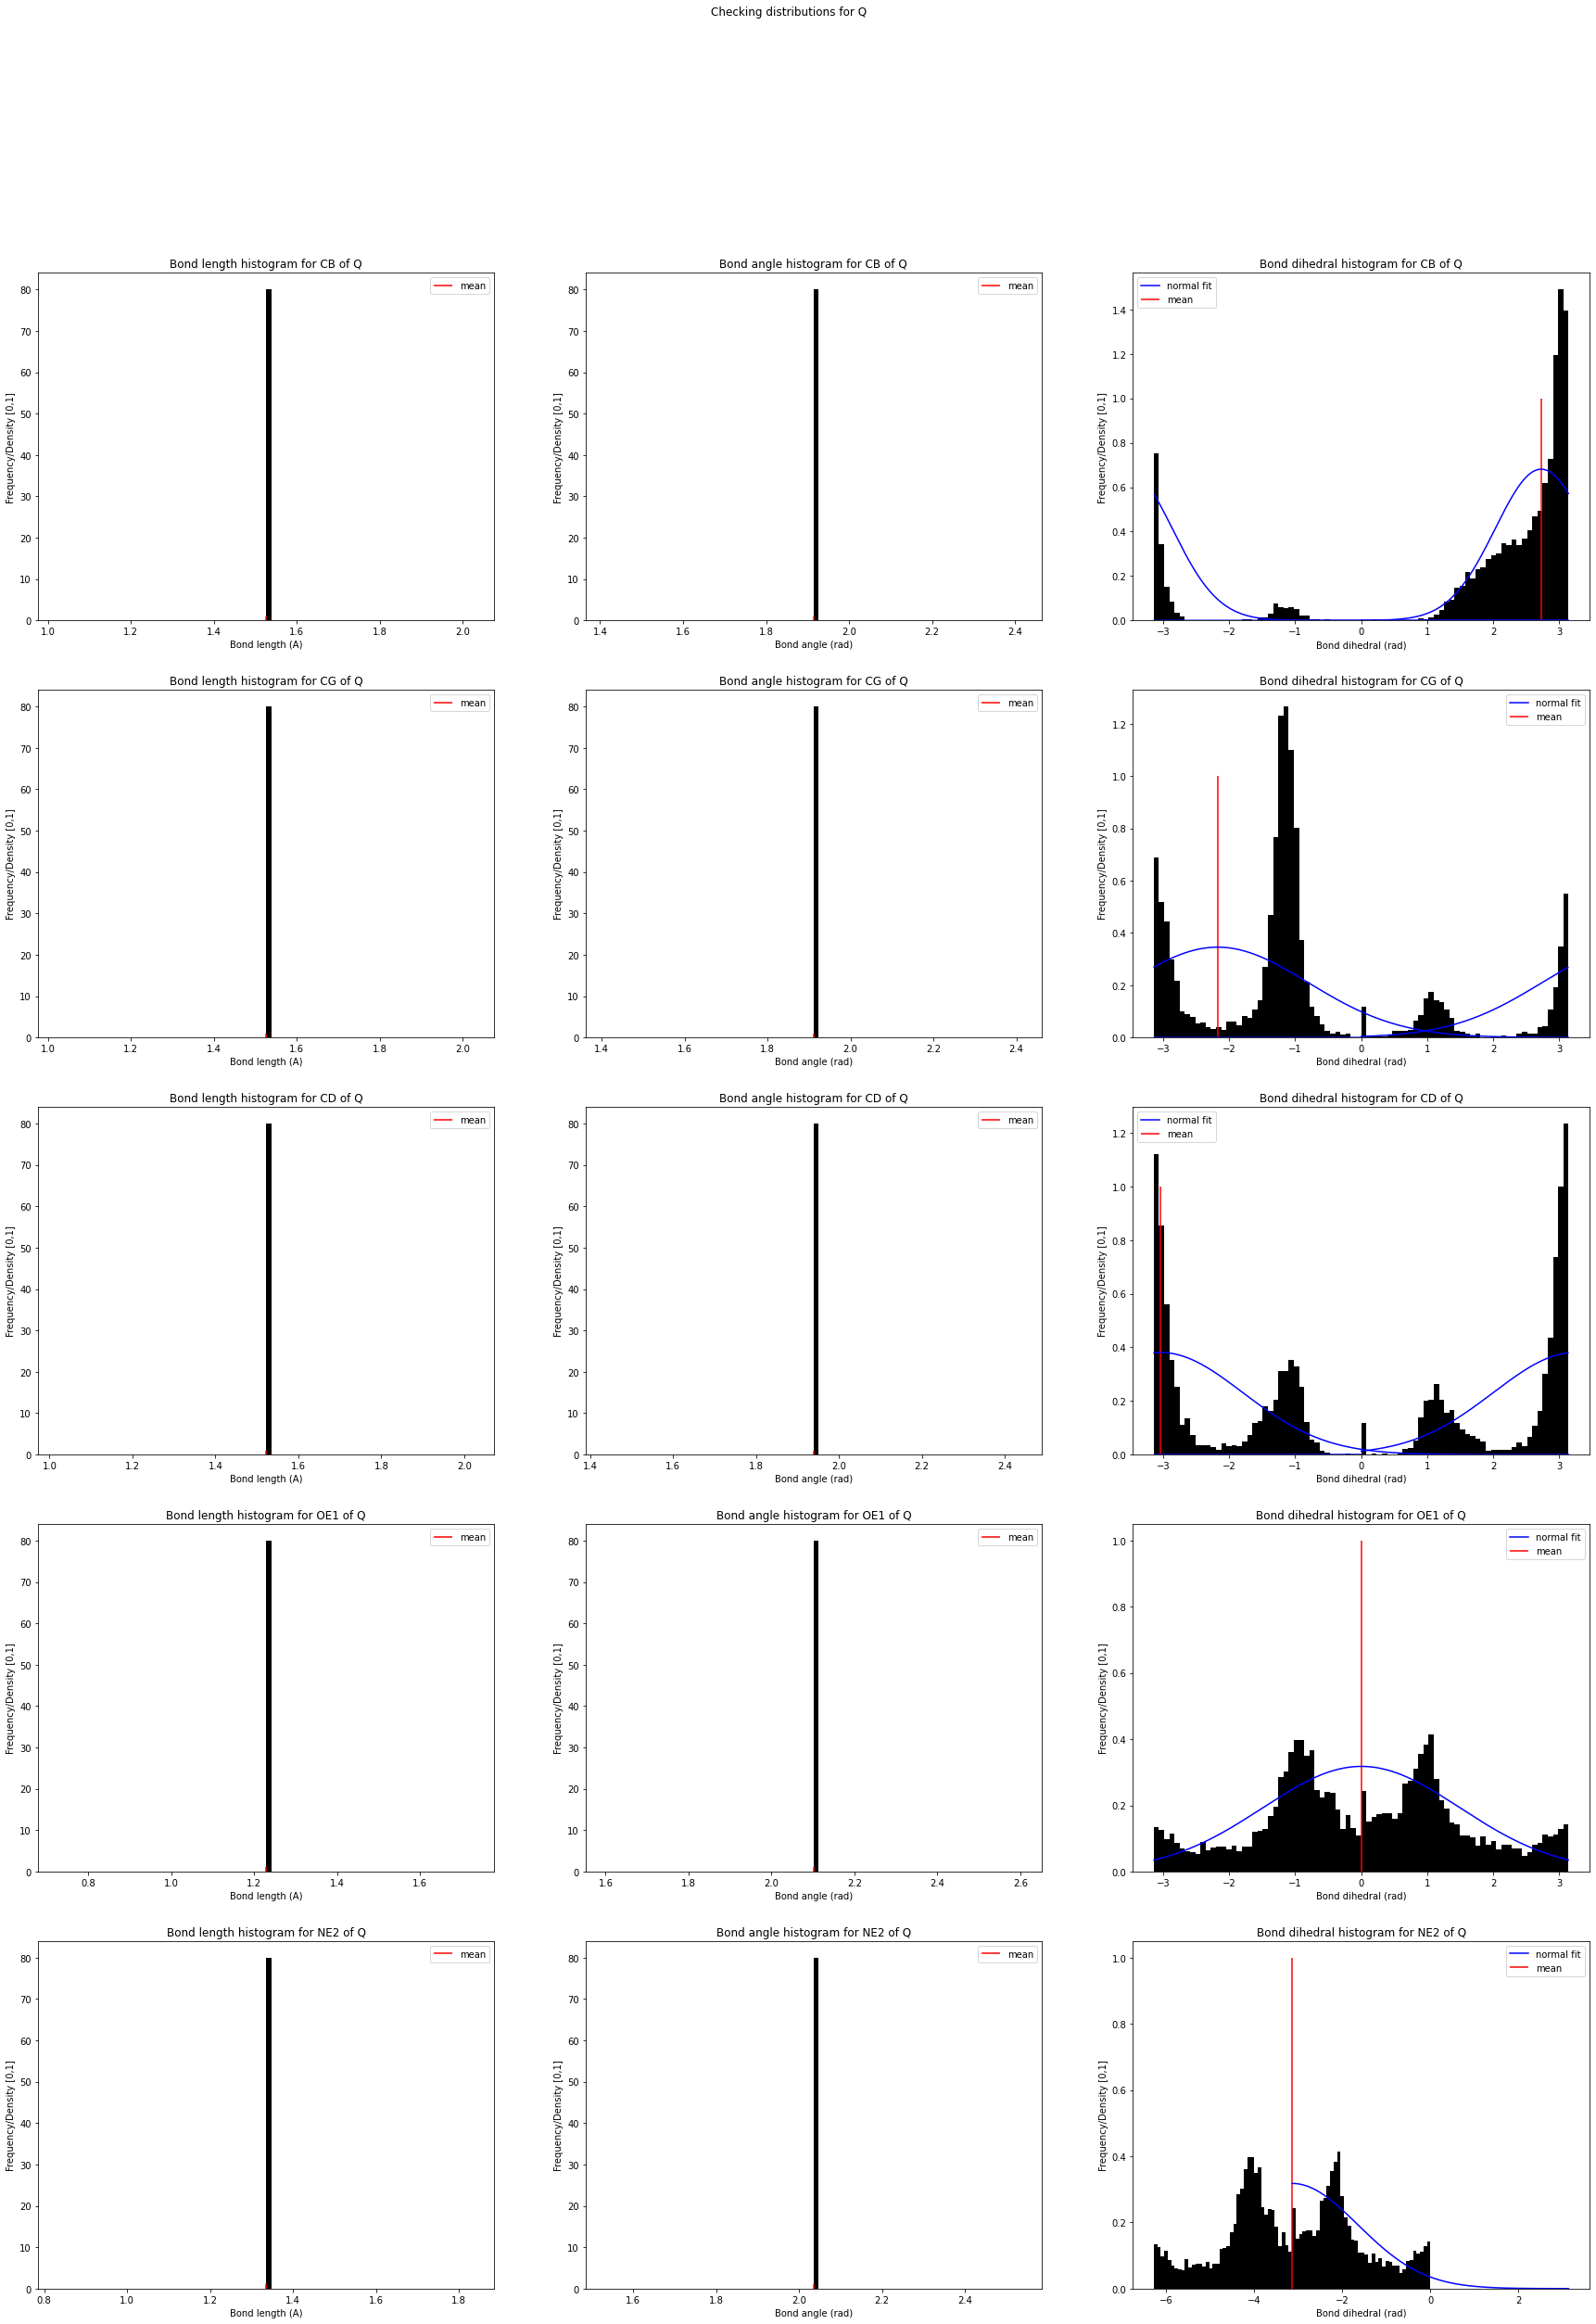

inverted mean needed in E in atom CB
inverted mean needed in E in atom CG
inverted mean needed in E in atom CD


<Figure size 432x288 with 0 Axes>

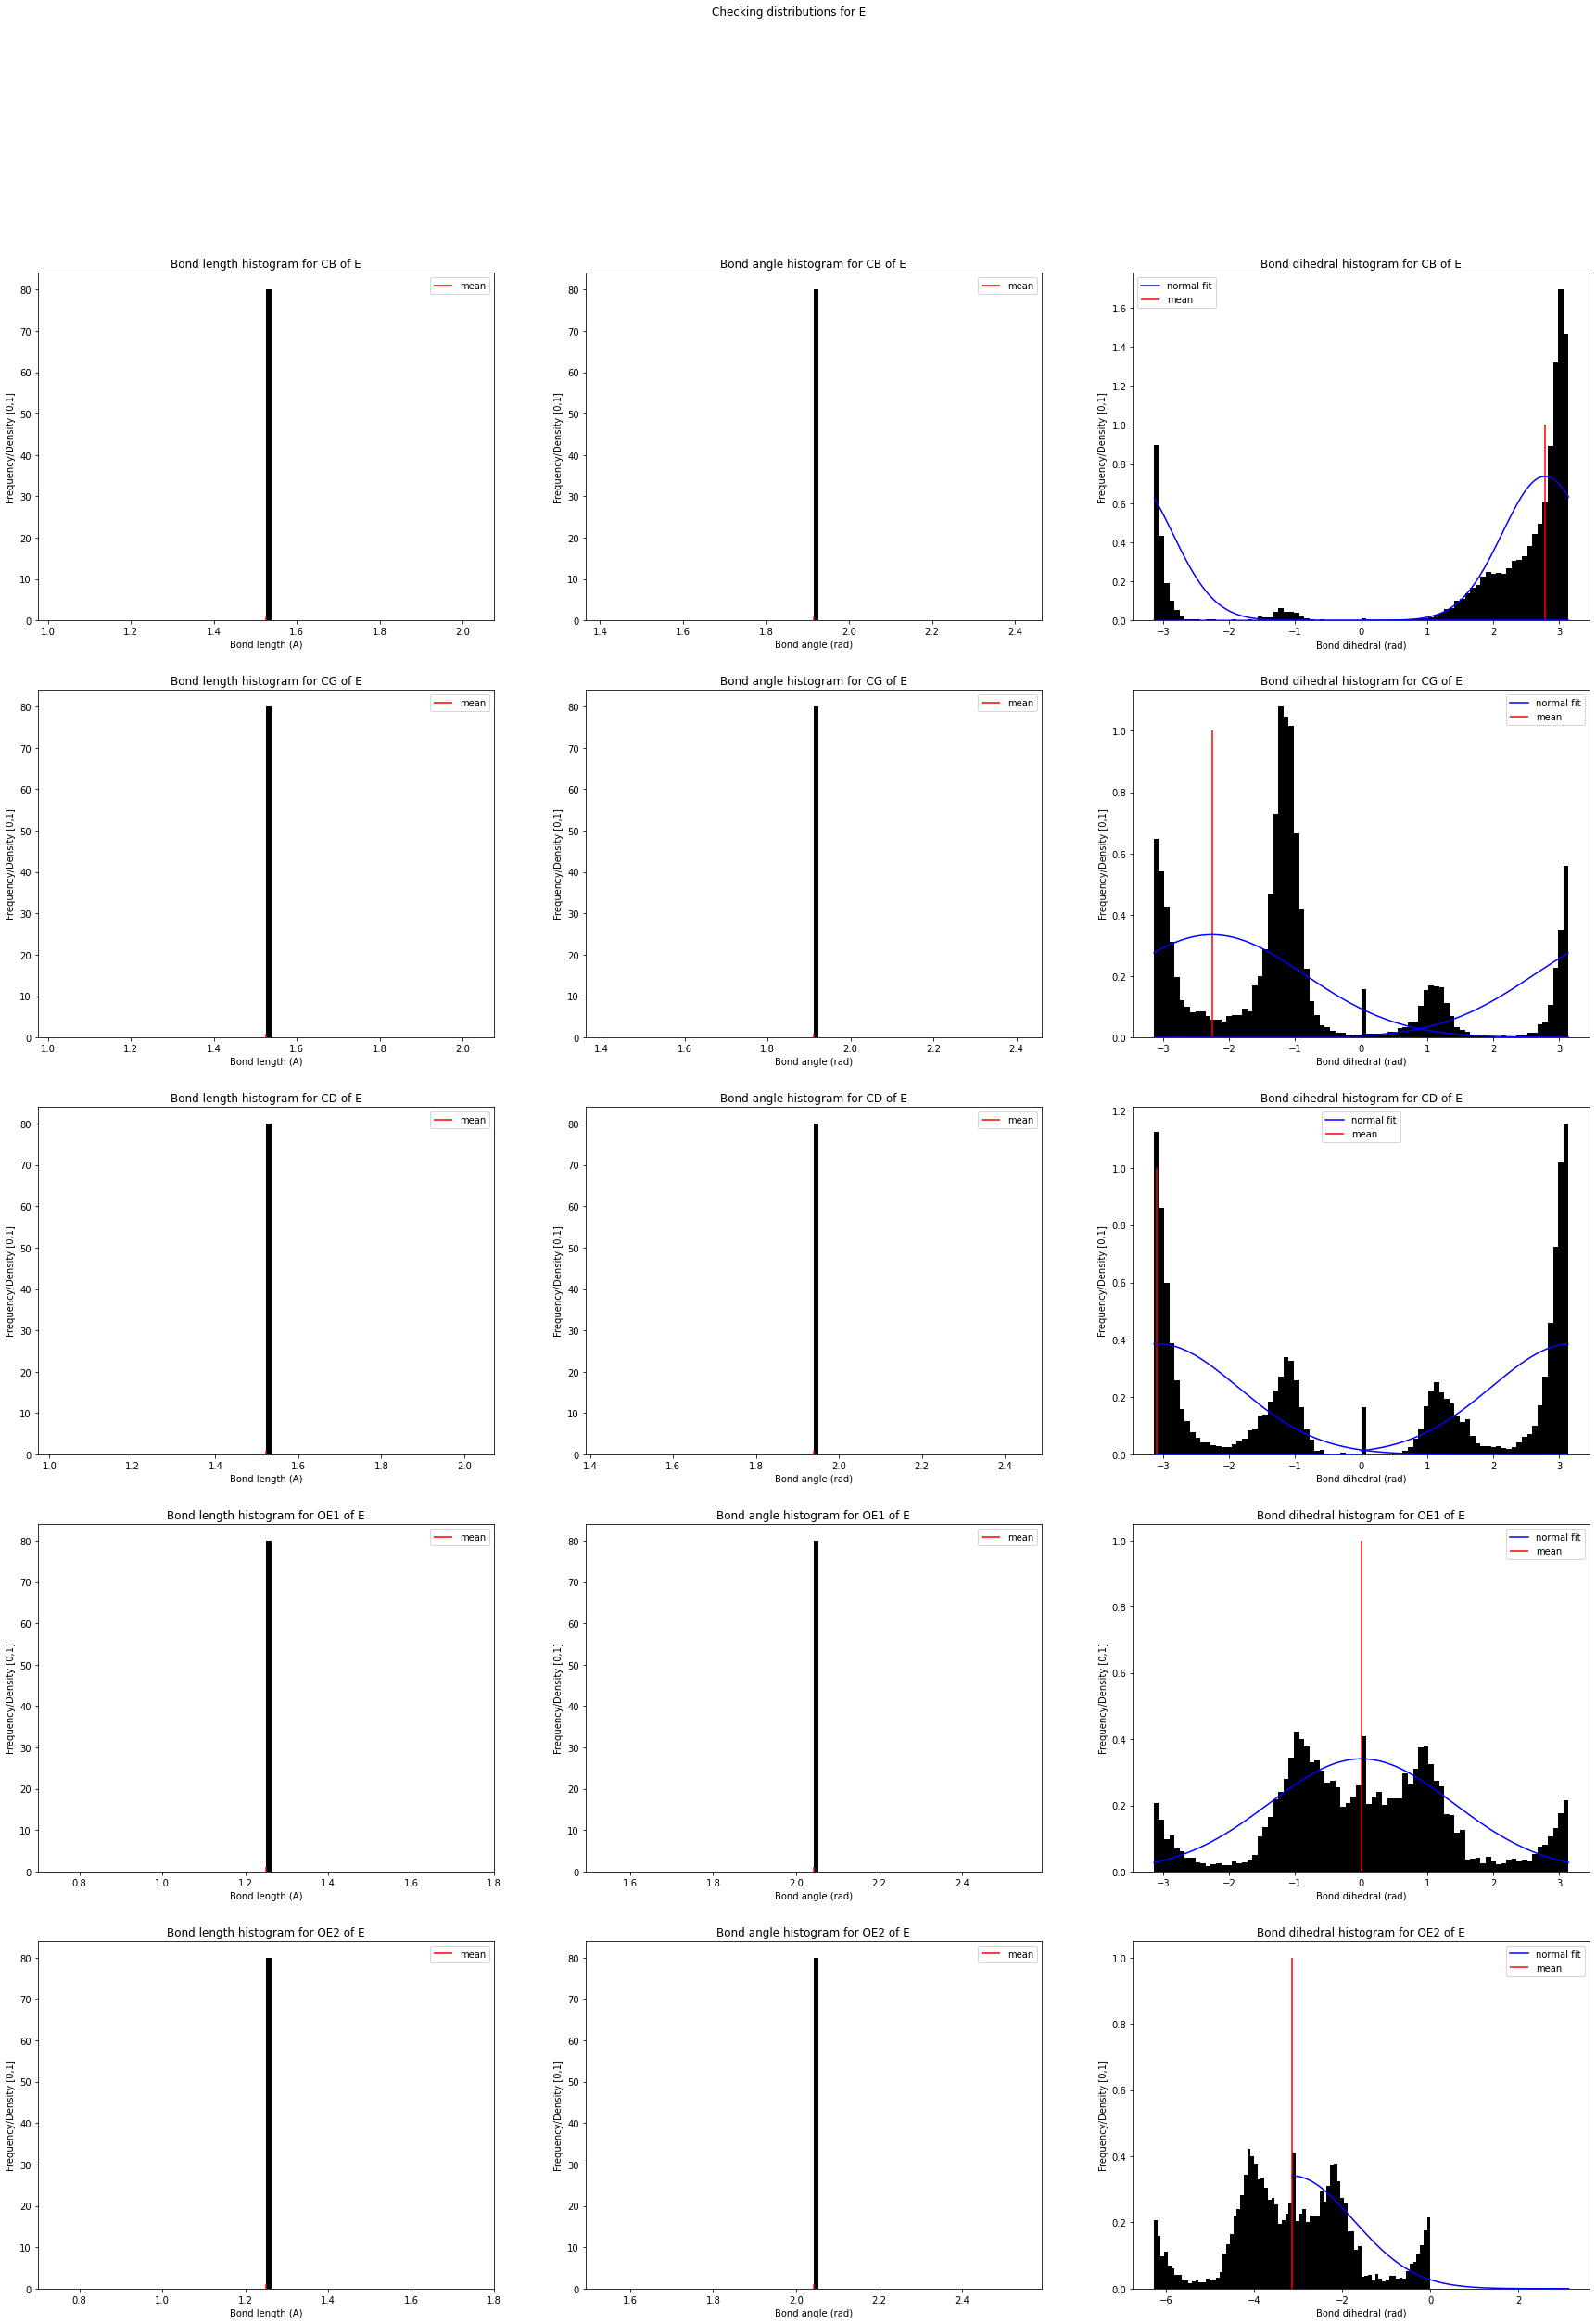

<Figure size 432x288 with 0 Axes>

inverted mean needed in H in atom CB
inverted mean needed in H in atom CG


<Figure size 432x288 with 0 Axes>

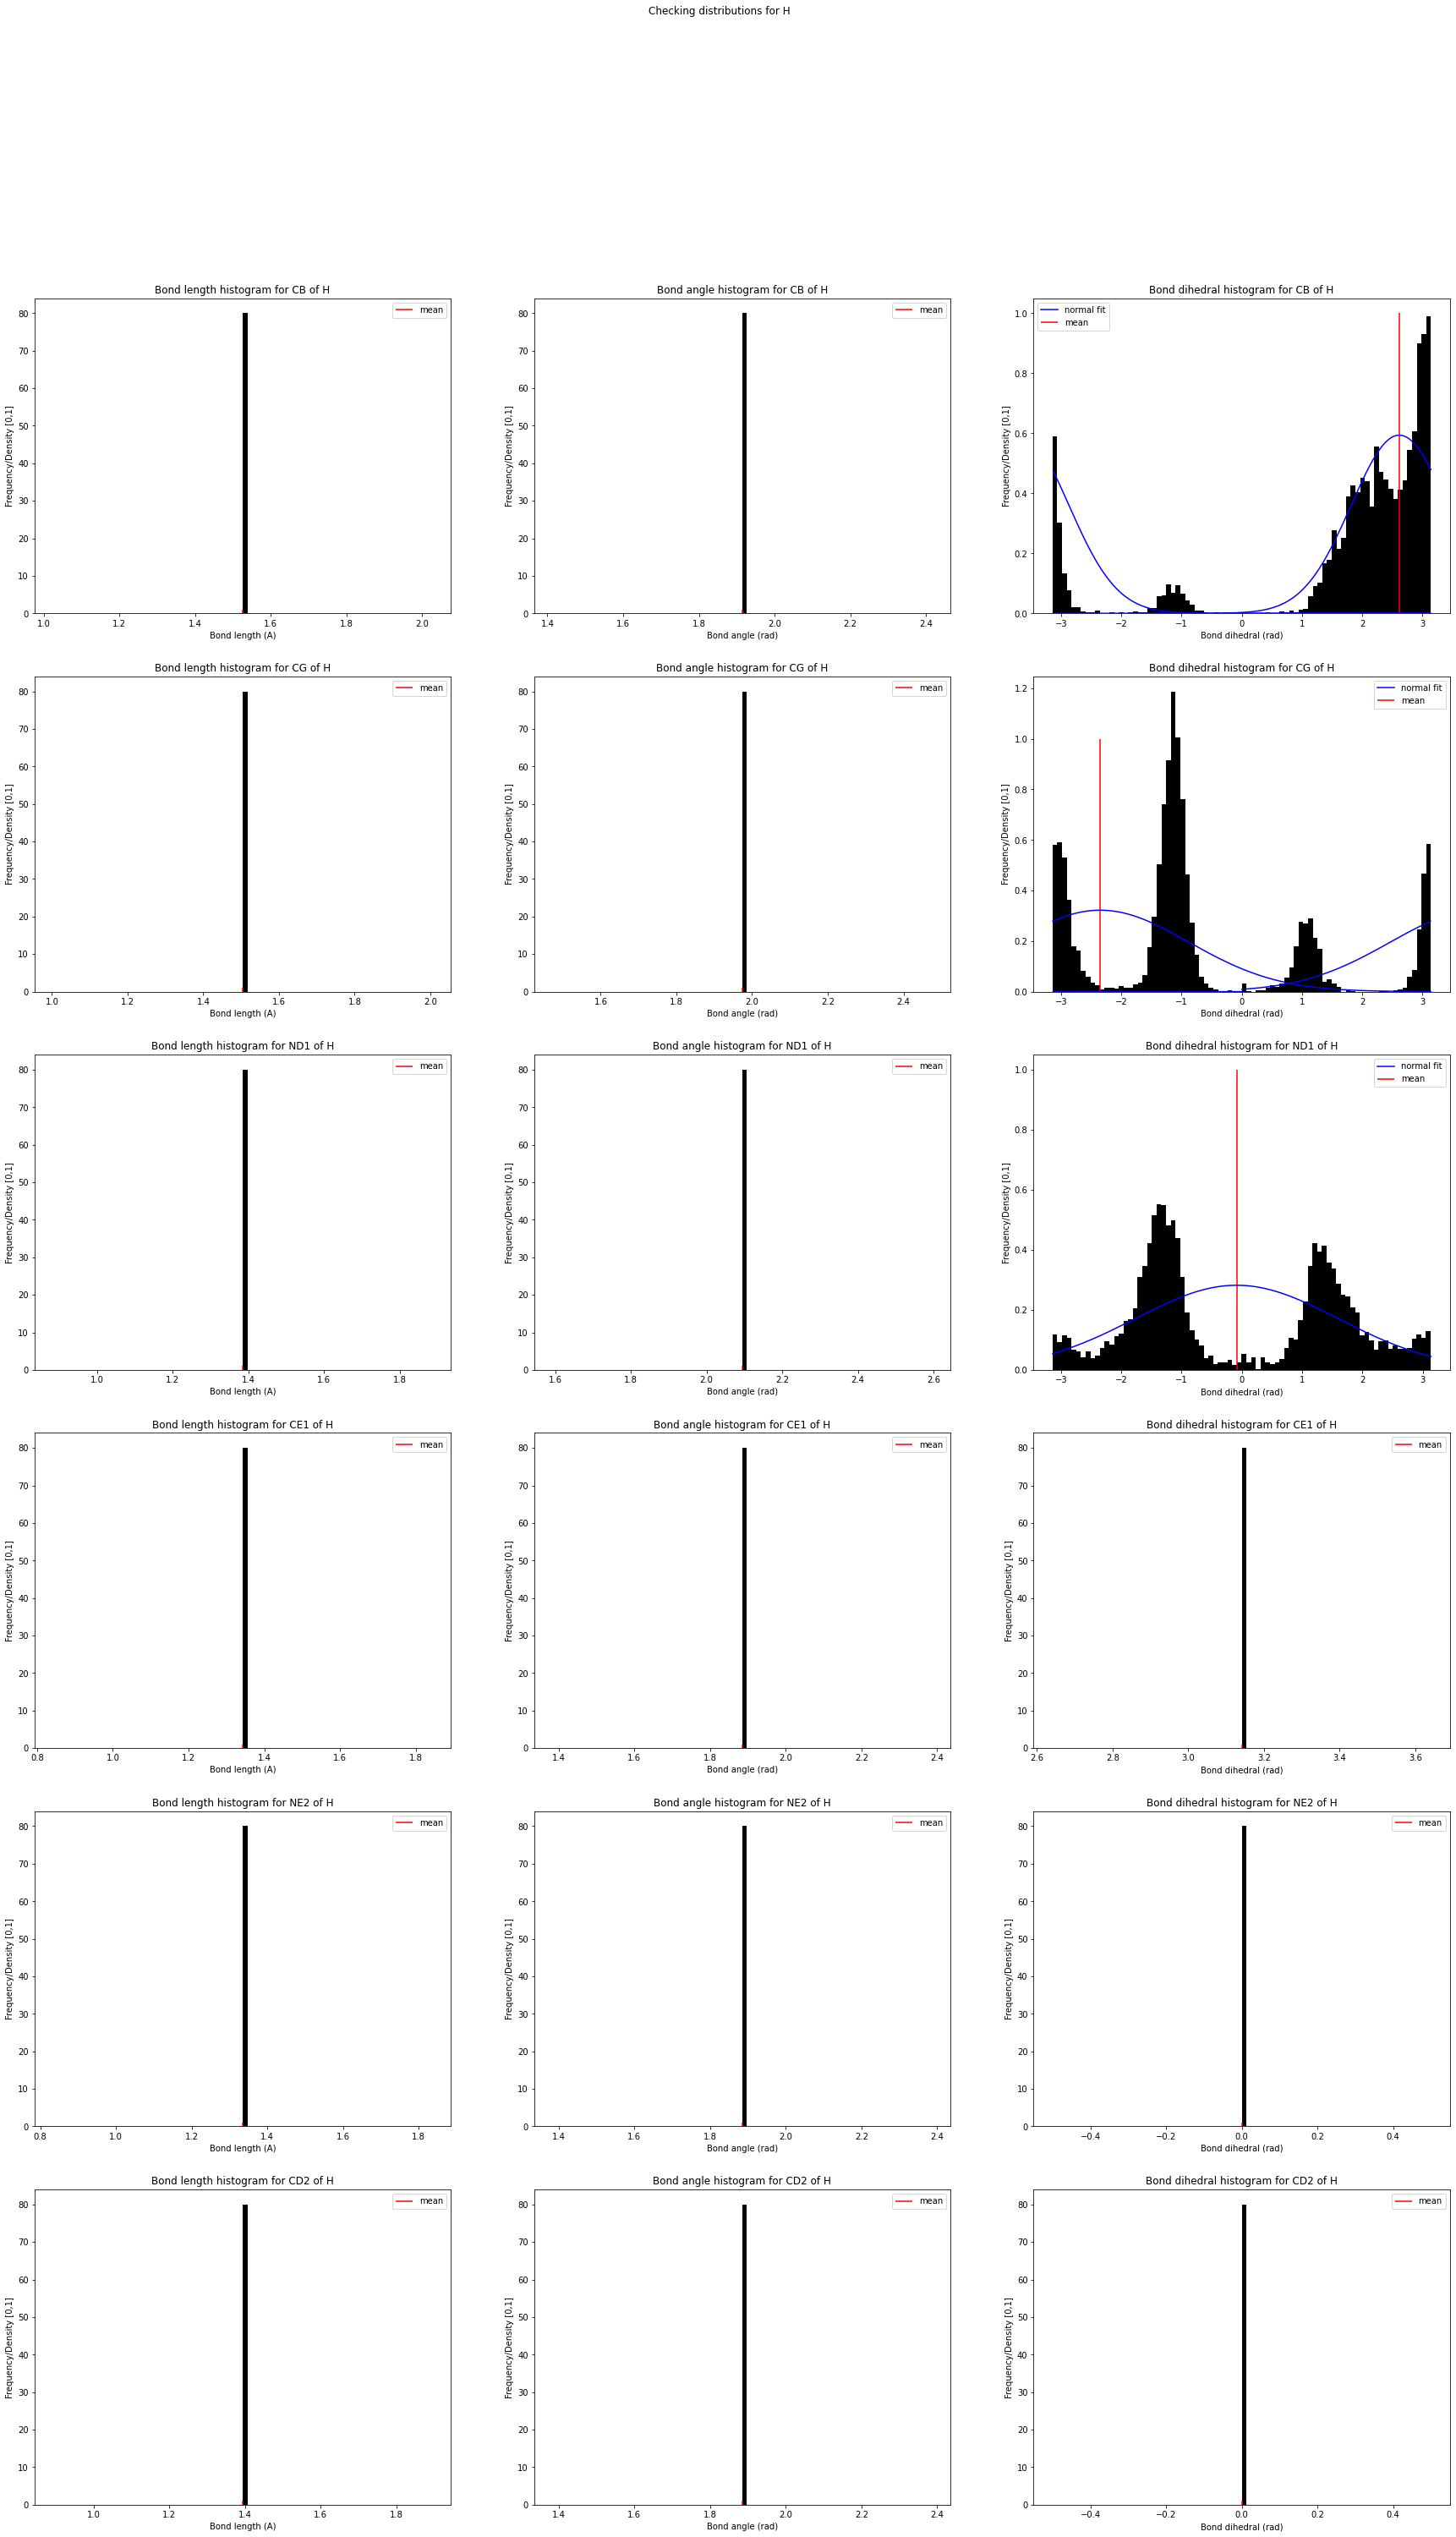

inverted mean needed in I in atom CB
inverted mean needed in I in atom CD1
inverted mean needed in I in atom CG2


<Figure size 432x288 with 0 Axes>

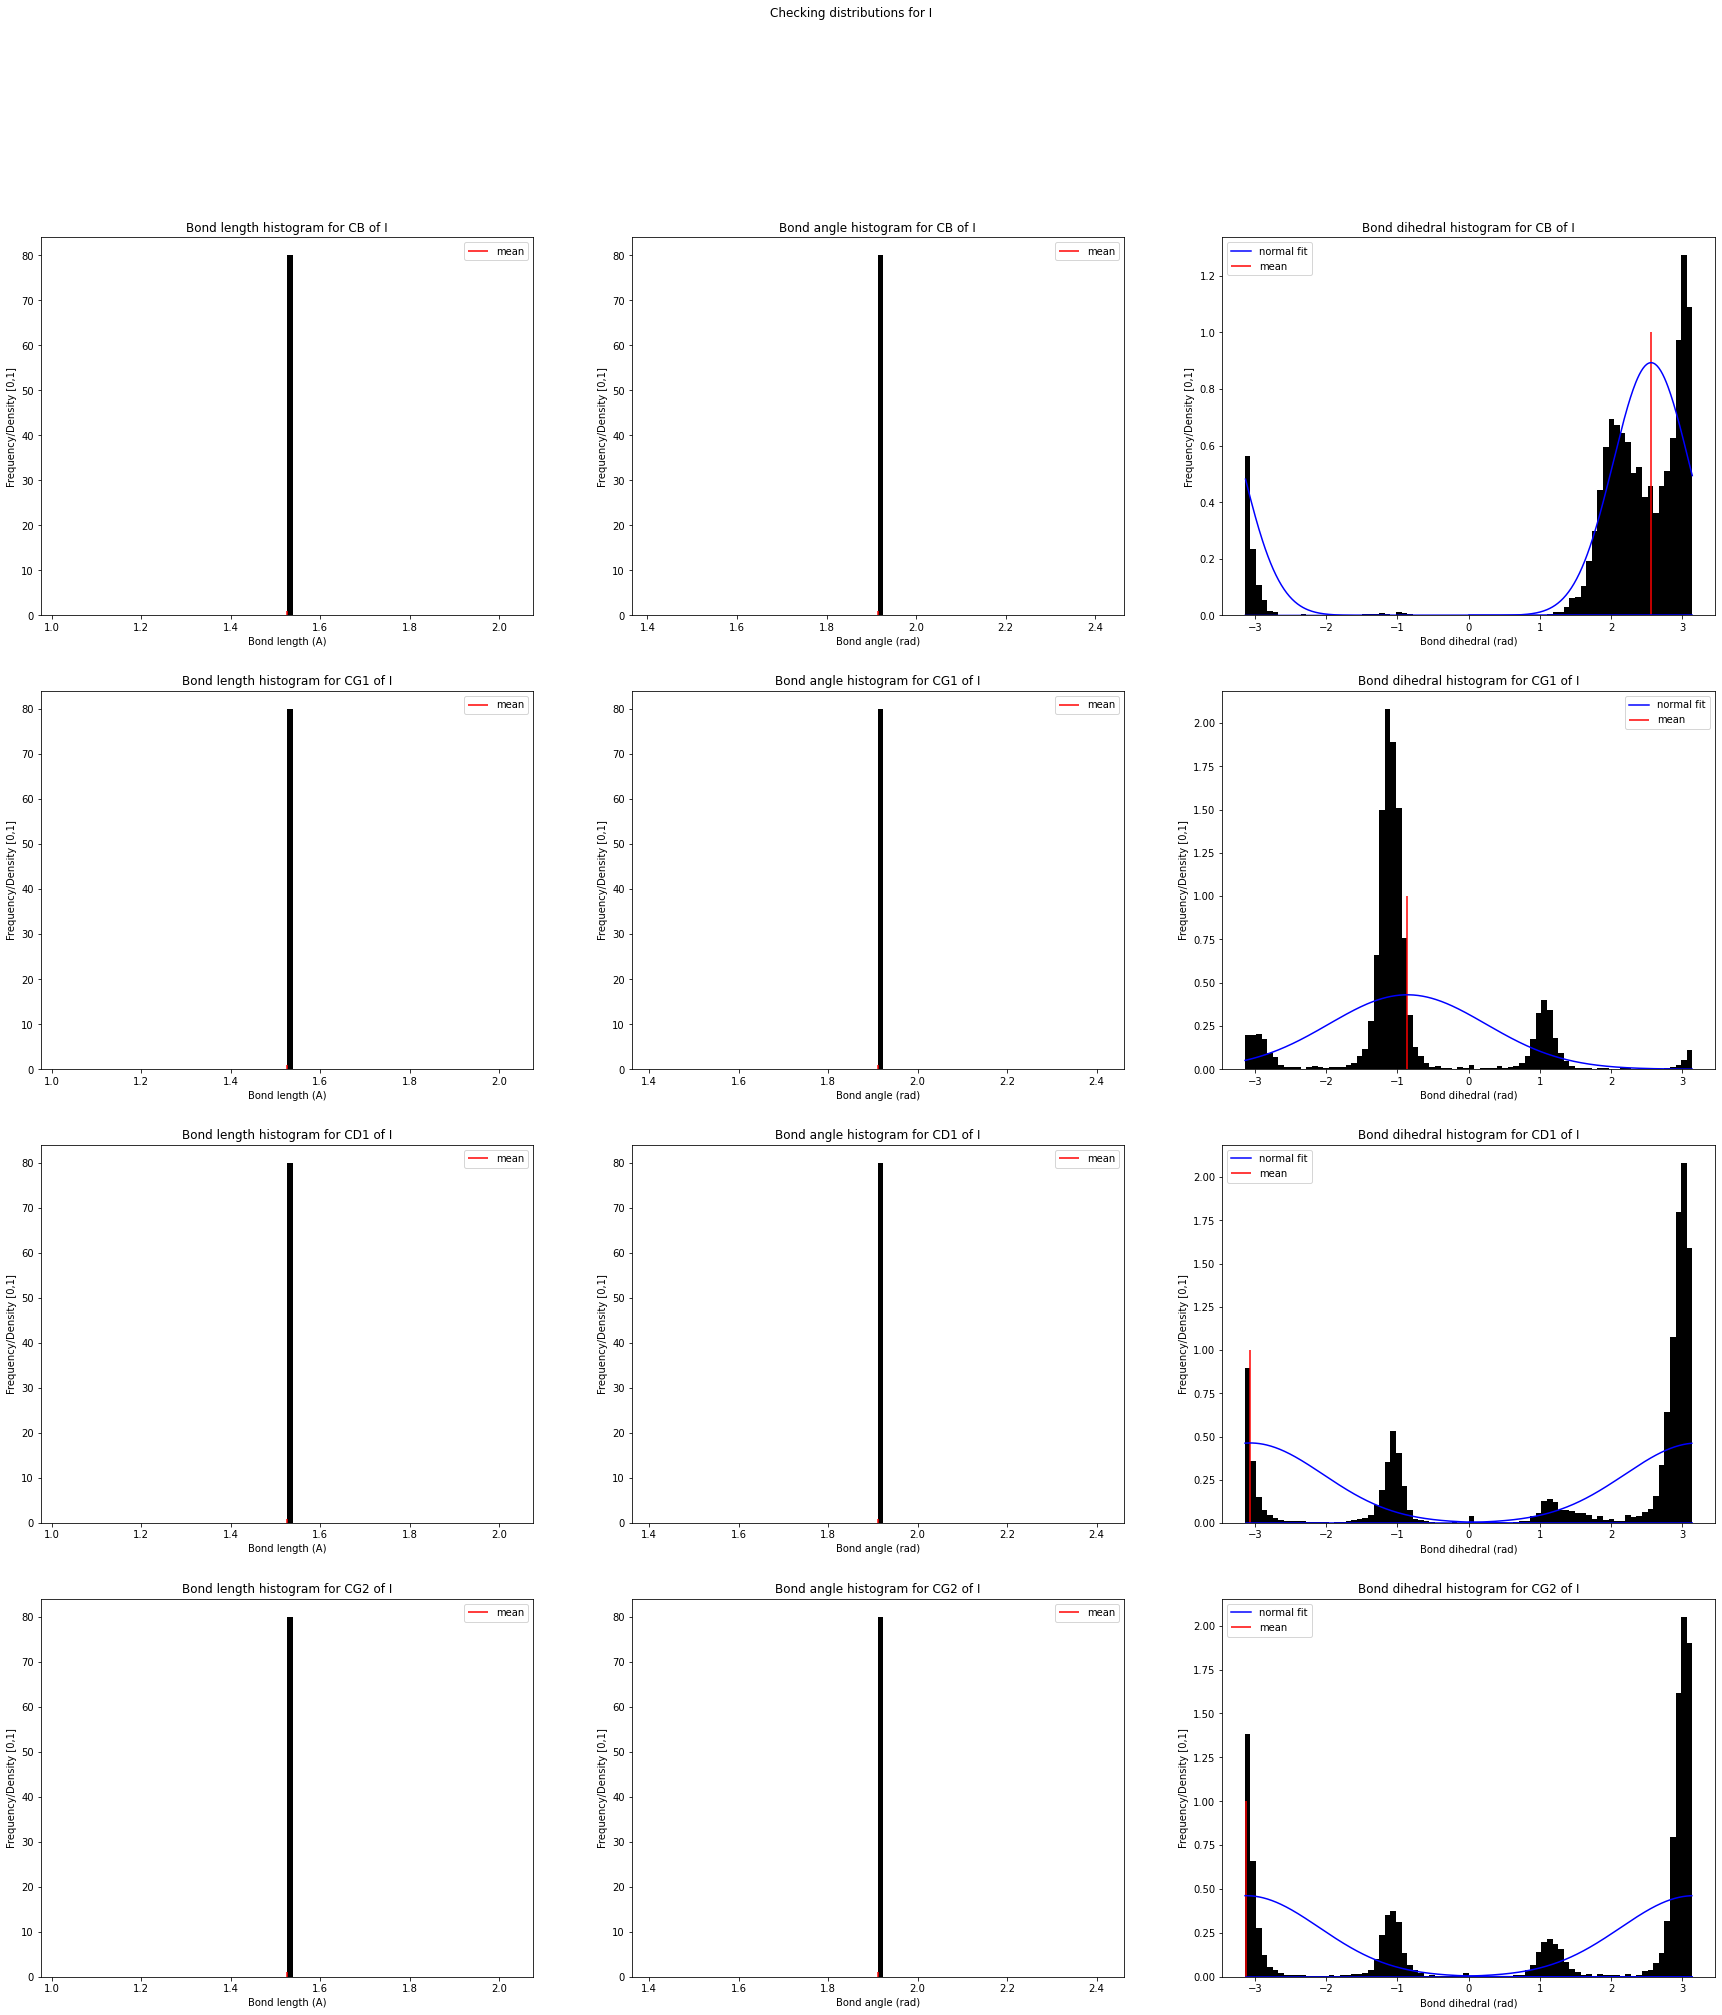

inverted mean needed in L in atom CB
inverted mean needed in L in atom CG
inverted mean needed in L in atom CD1
inverted mean needed in L in atom CD2


<Figure size 432x288 with 0 Axes>

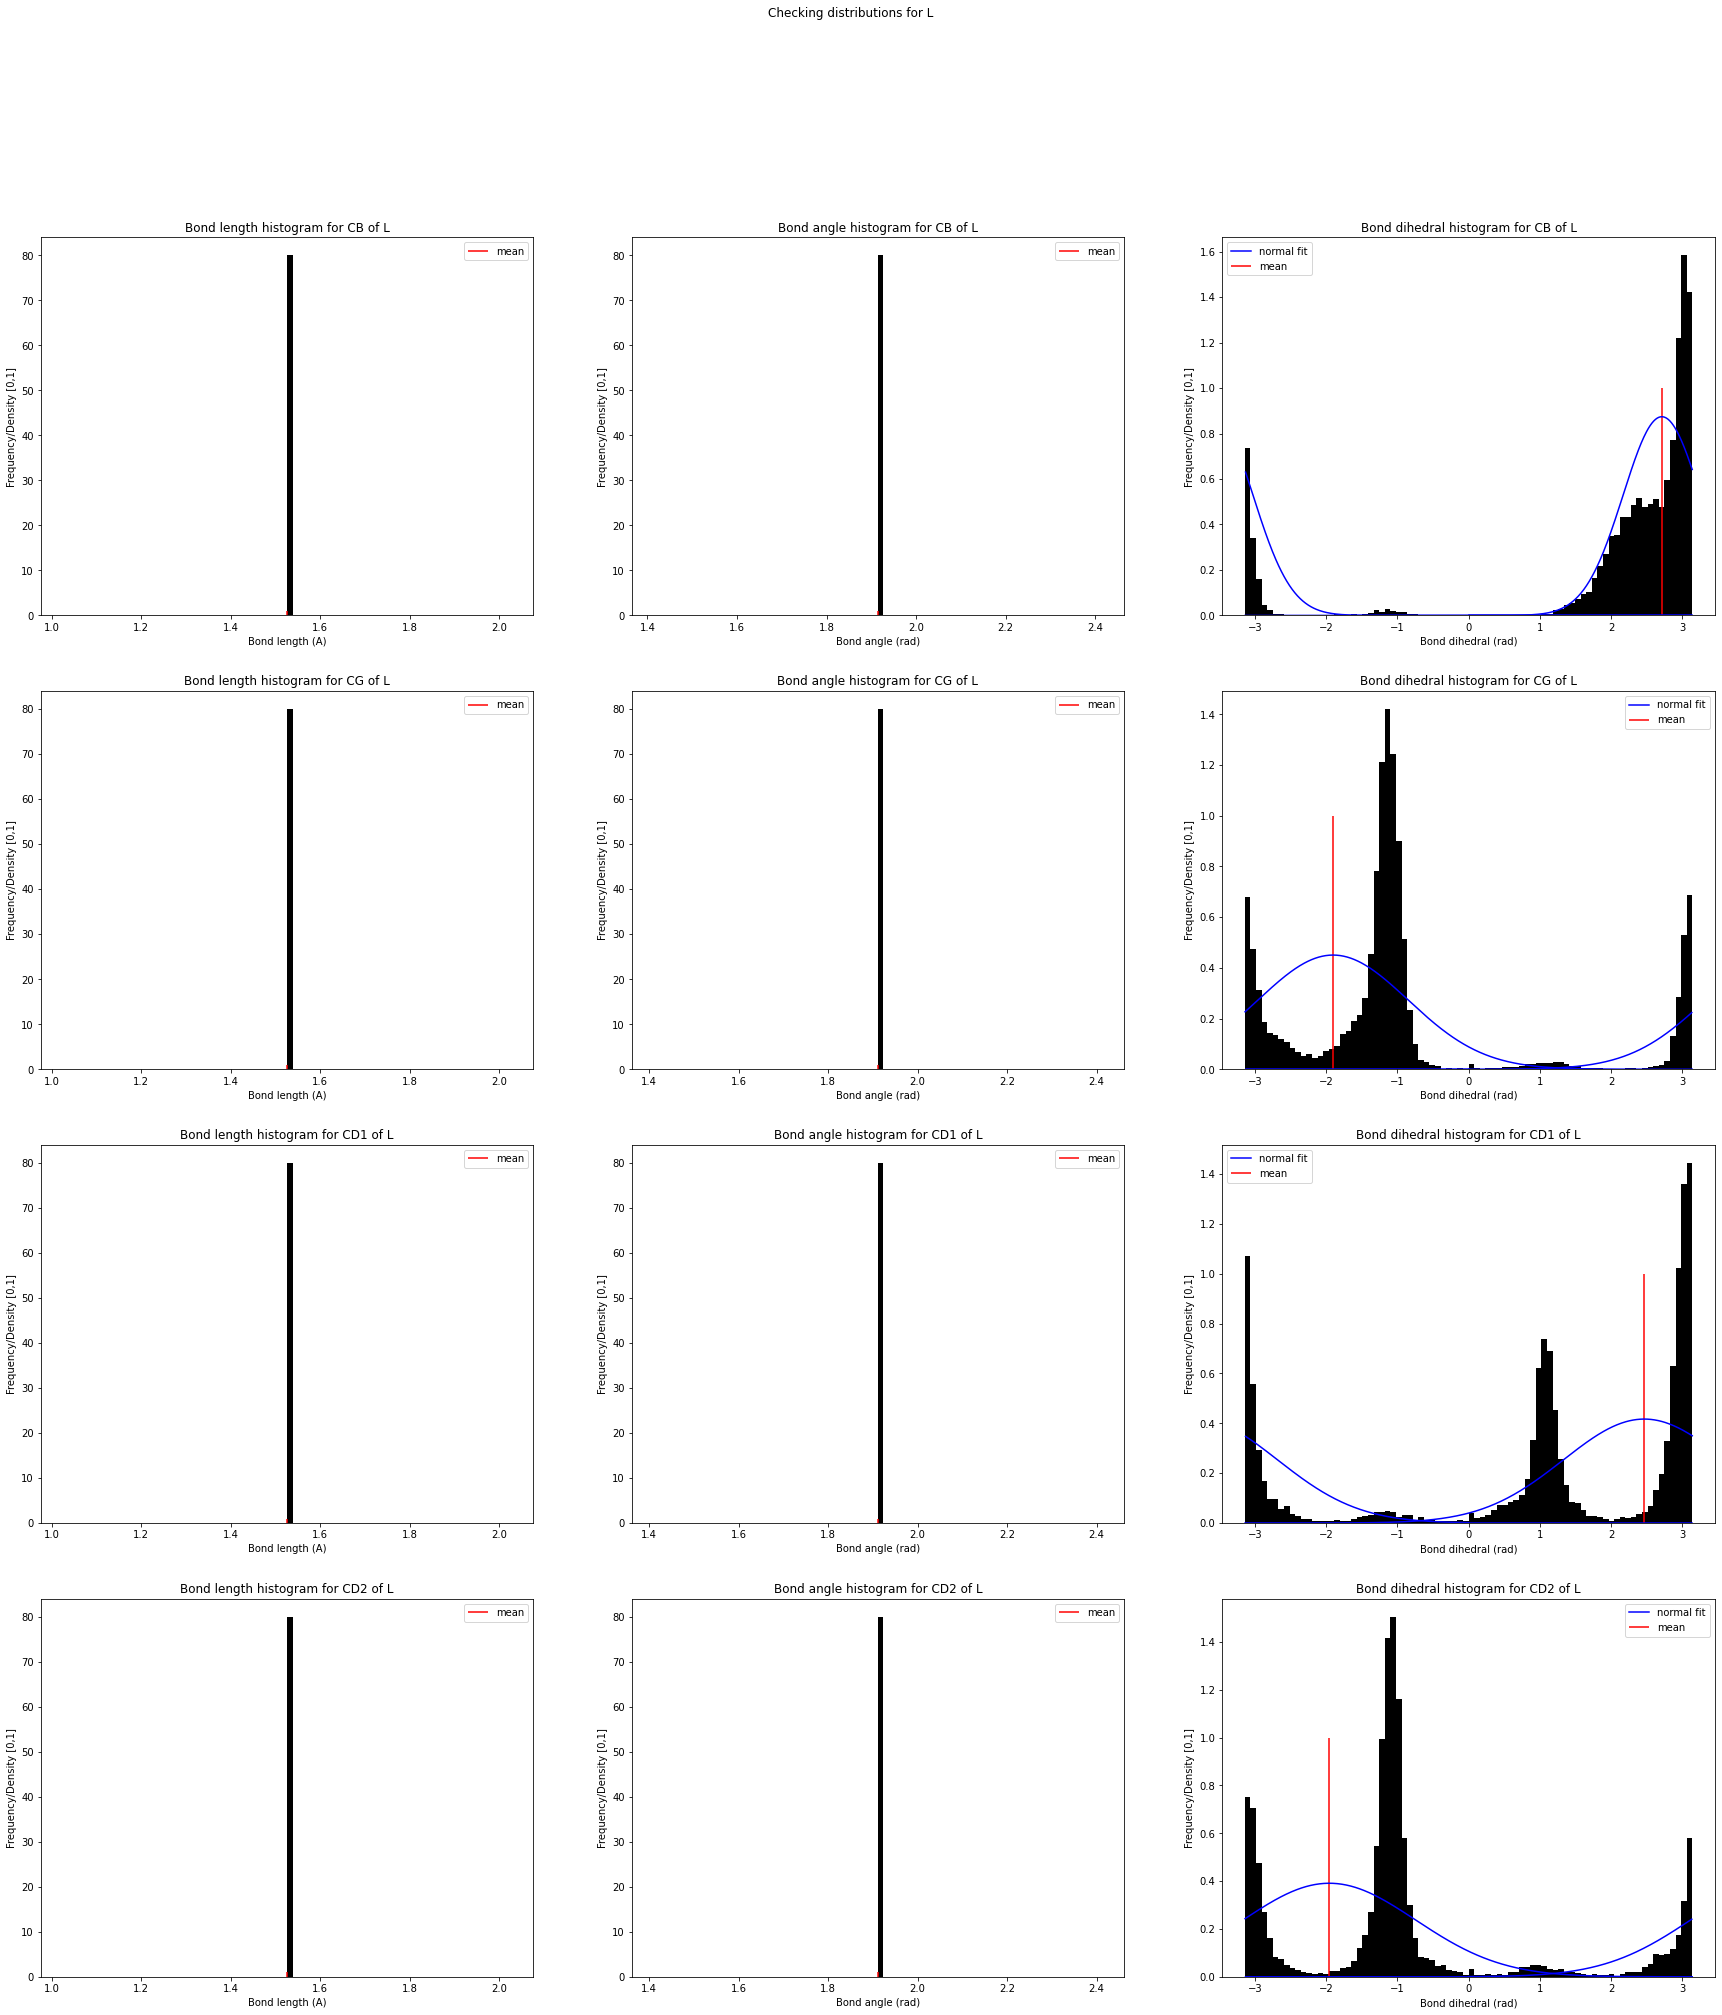

inverted mean needed in K in atom CB
inverted mean needed in K in atom CG
inverted mean needed in K in atom CD
inverted mean needed in K in atom CE
inverted mean needed in K in atom NZ


<Figure size 432x288 with 0 Axes>

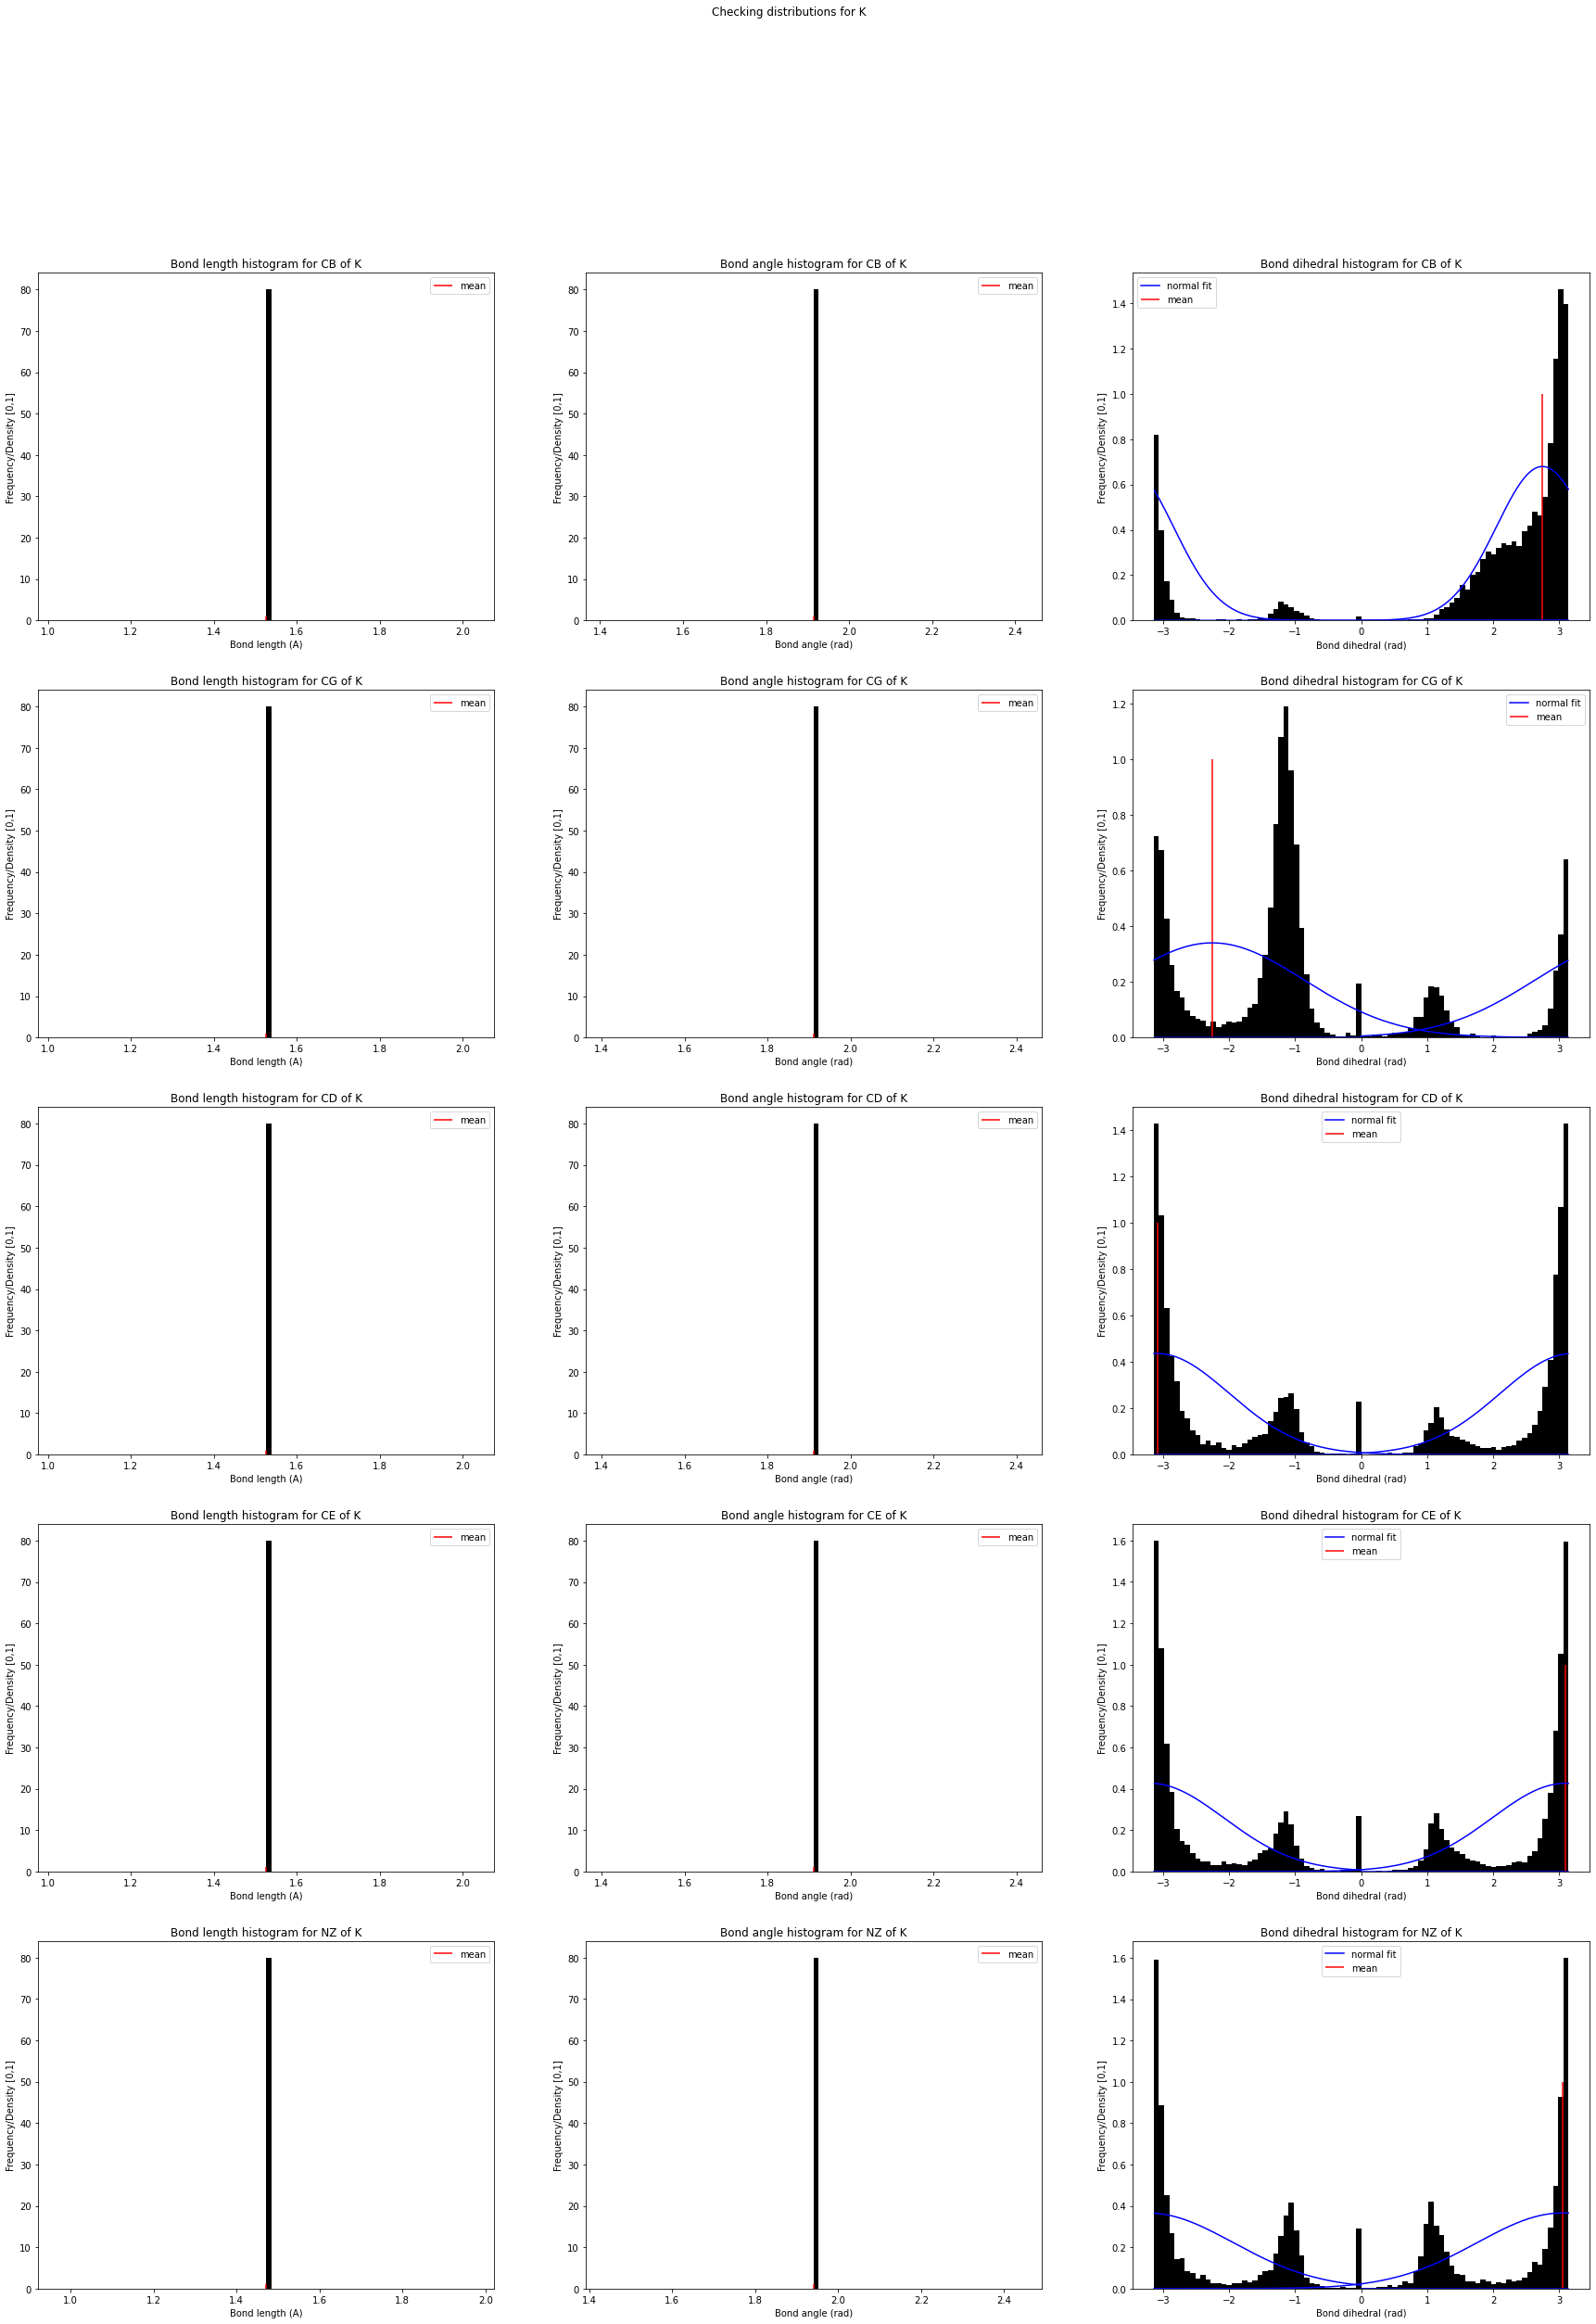

inverted mean needed in M in atom CB
inverted mean needed in M in atom CG
inverted mean needed in M in atom SD


<Figure size 432x288 with 0 Axes>

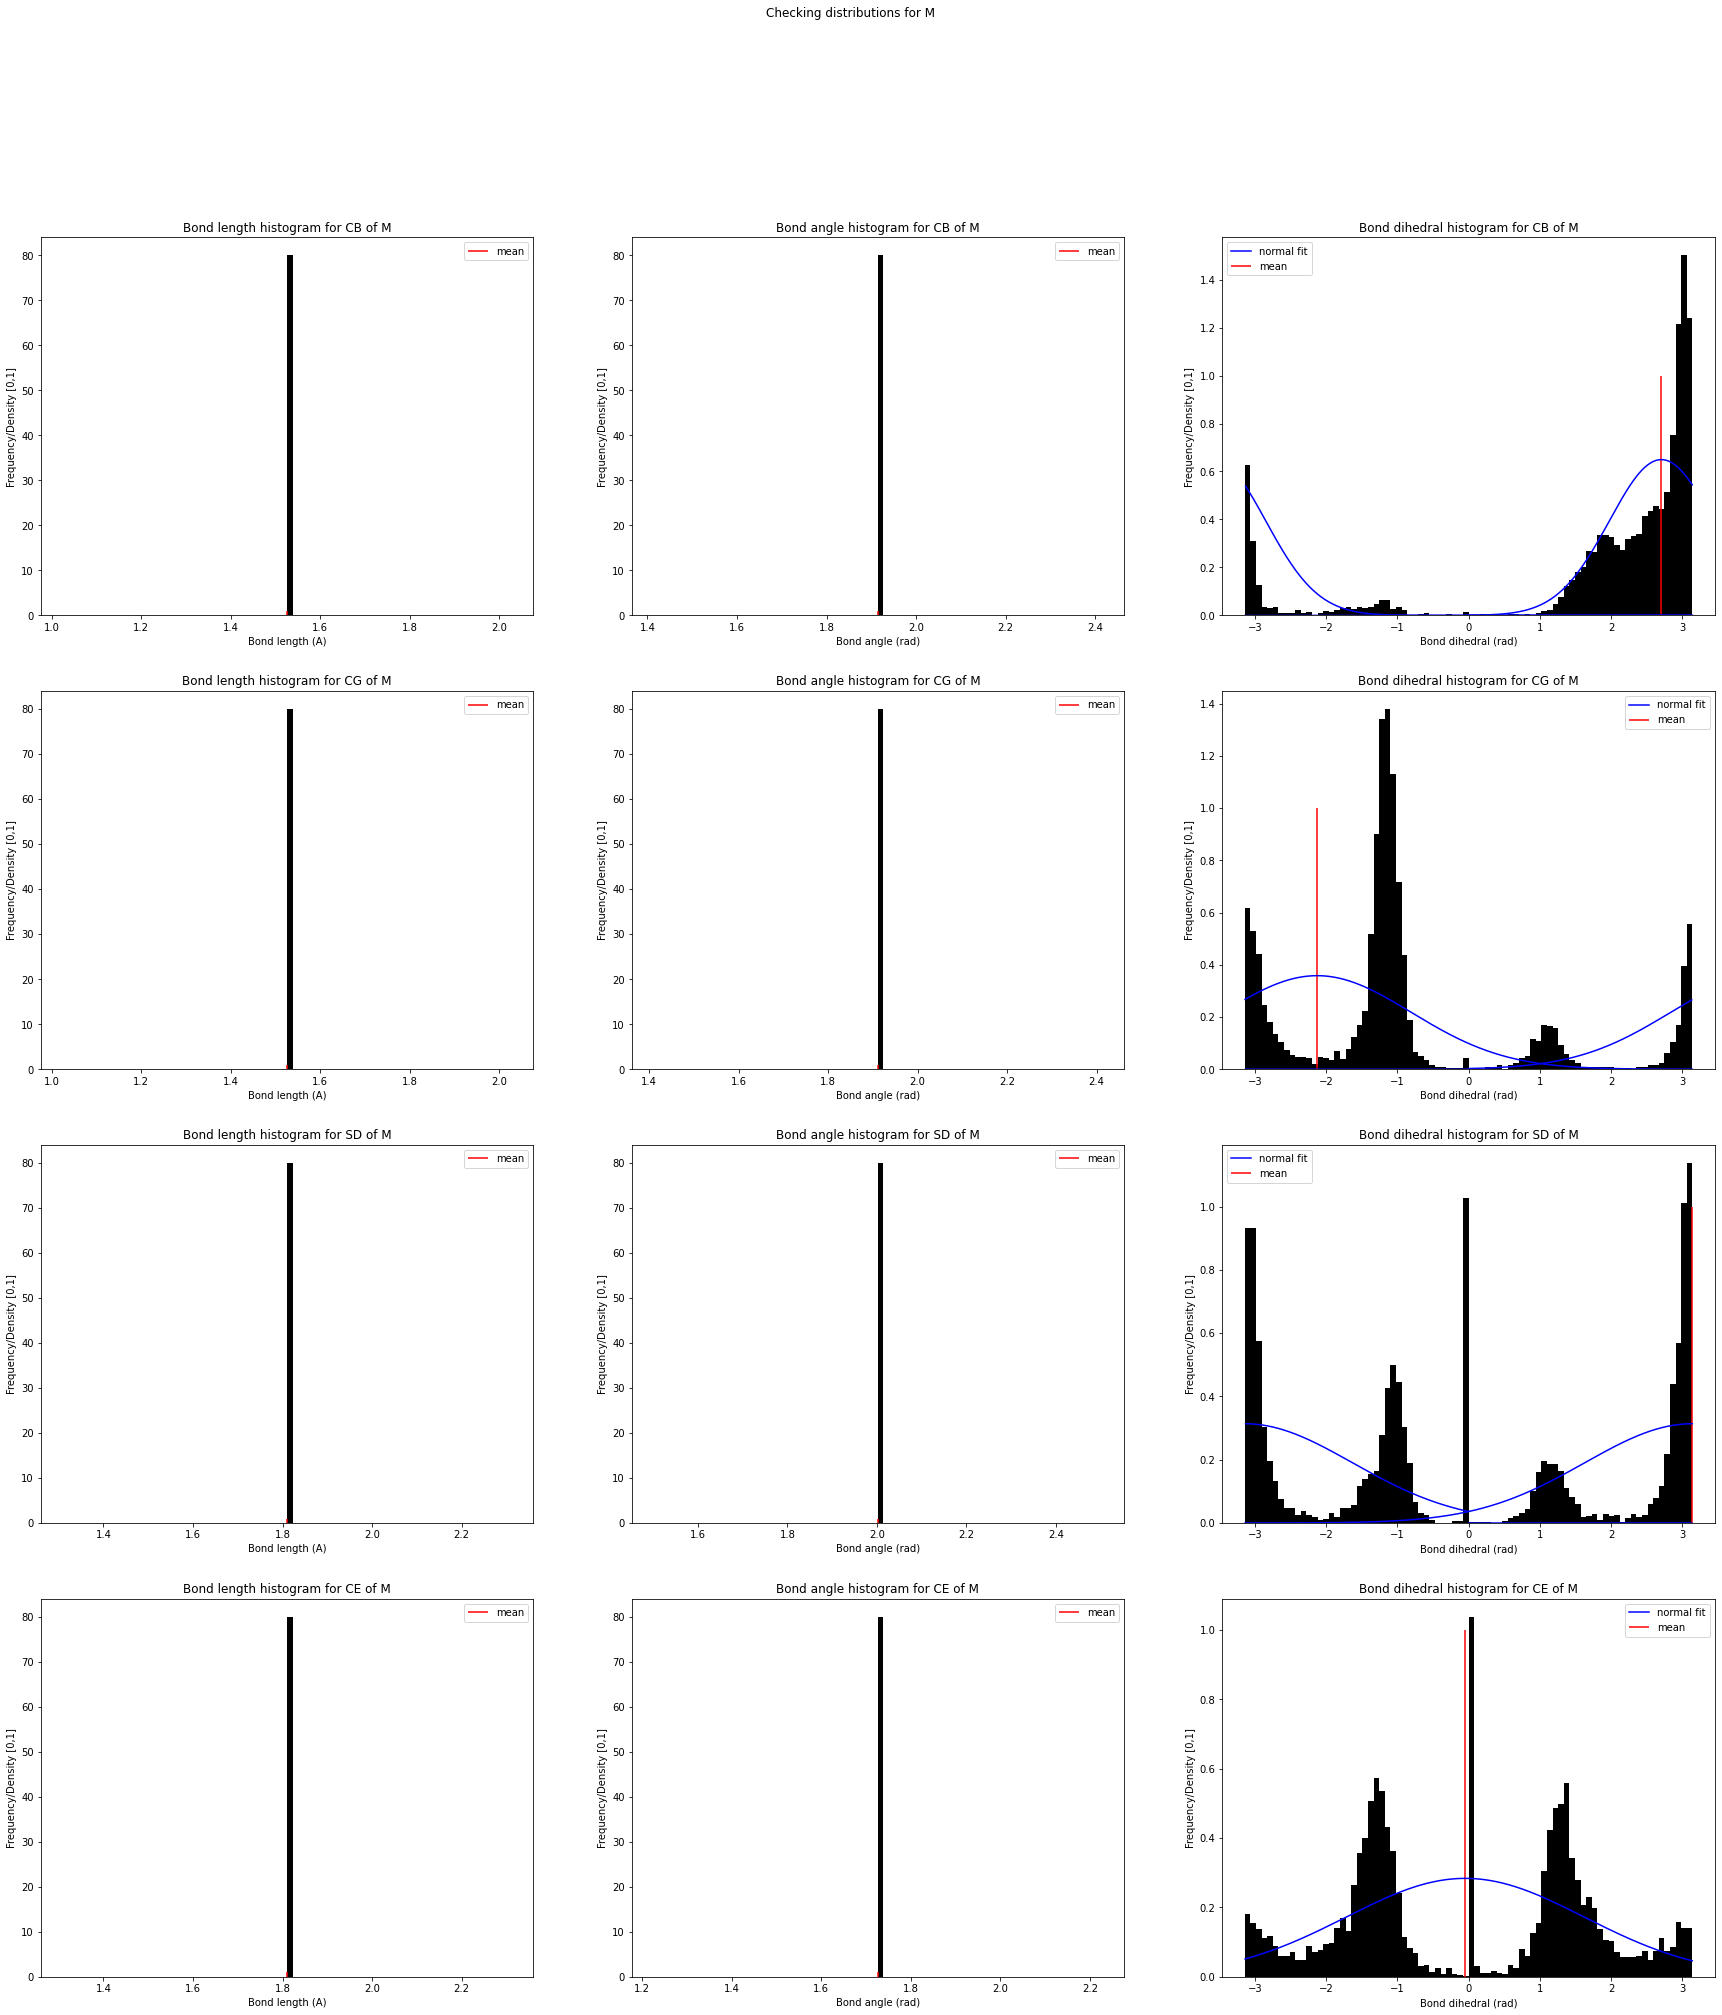

inverted mean needed in F in atom CB
inverted mean needed in F in atom CG


<Figure size 432x288 with 0 Axes>

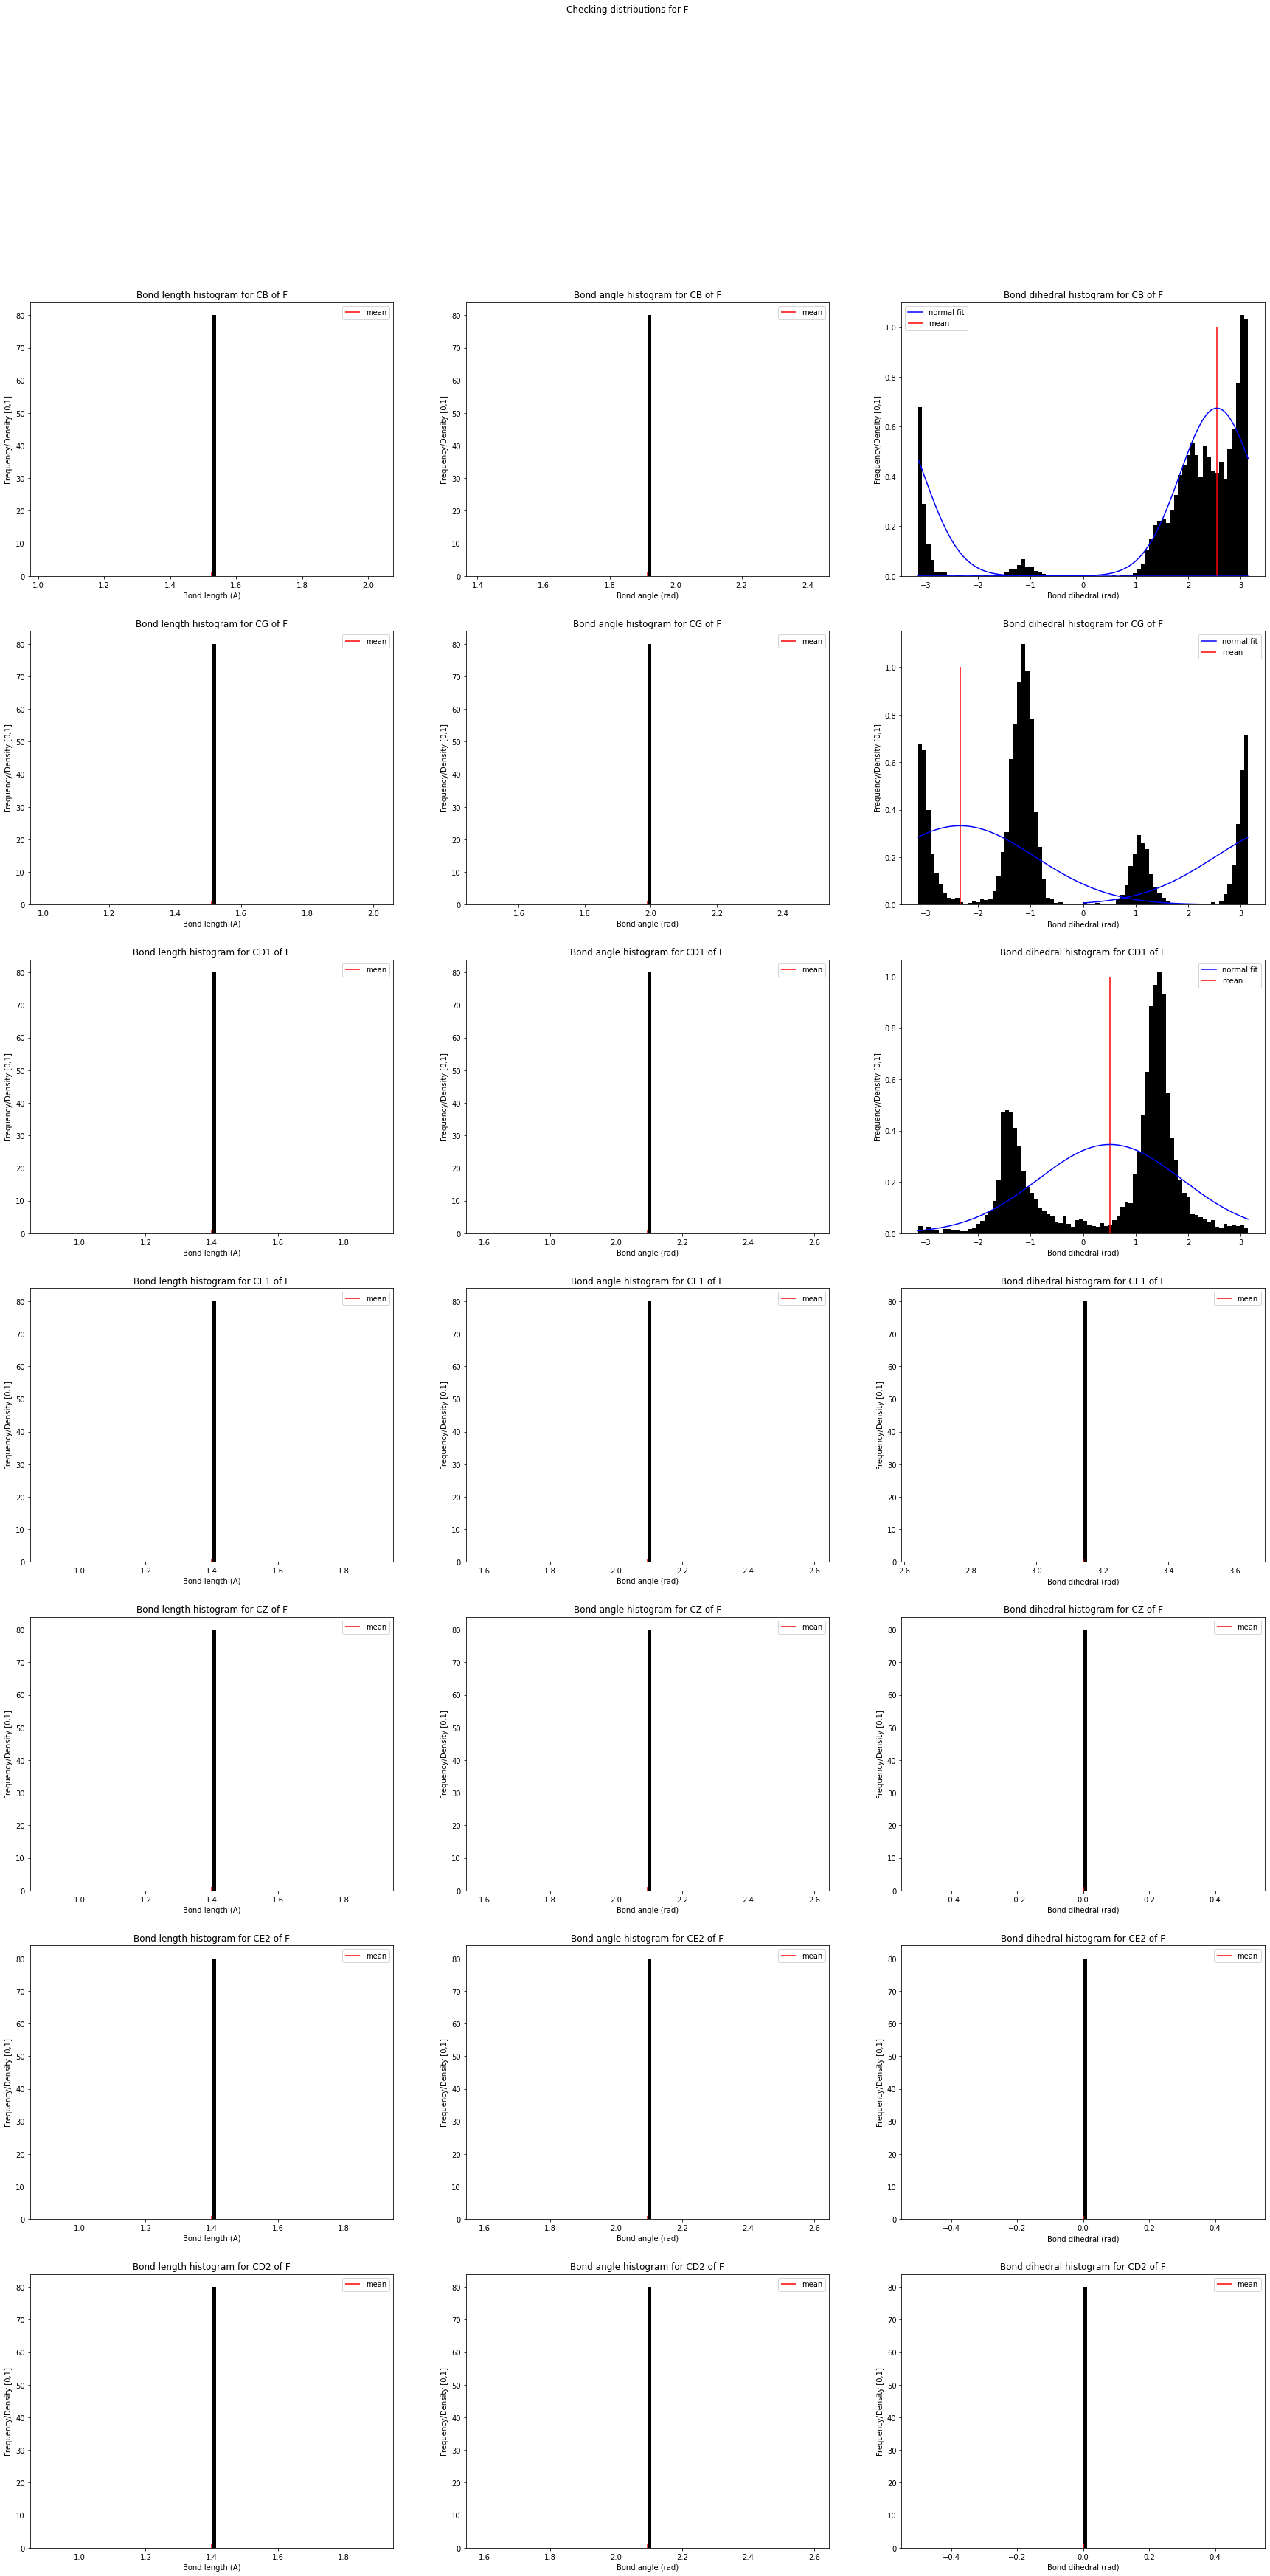

inverted mean needed in P in atom CB


<Figure size 432x288 with 0 Axes>

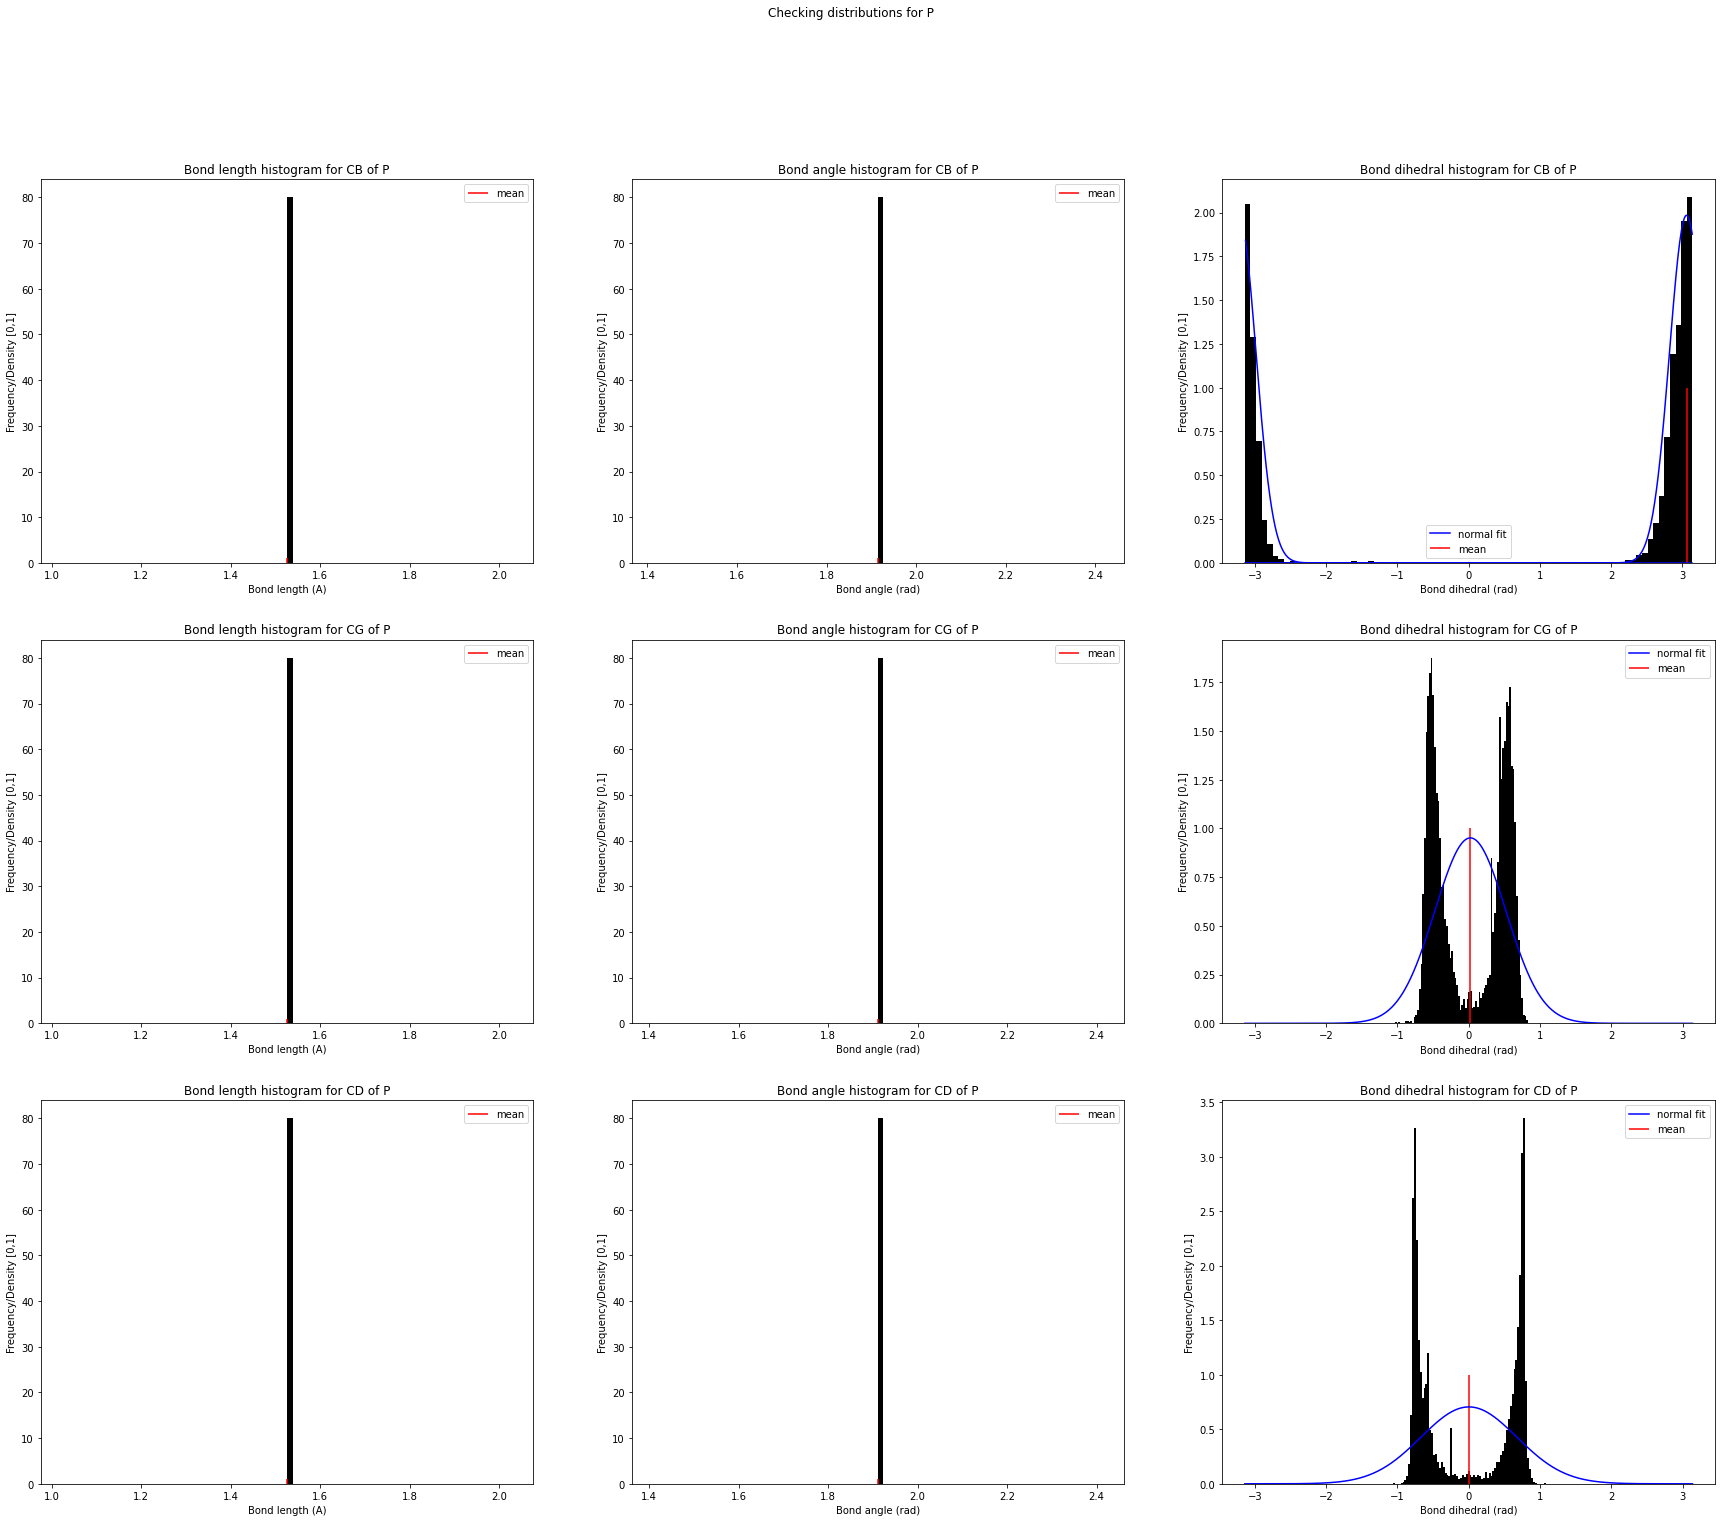

inverted mean needed in S in atom CB
inverted mean needed in S in atom OG


<Figure size 432x288 with 0 Axes>

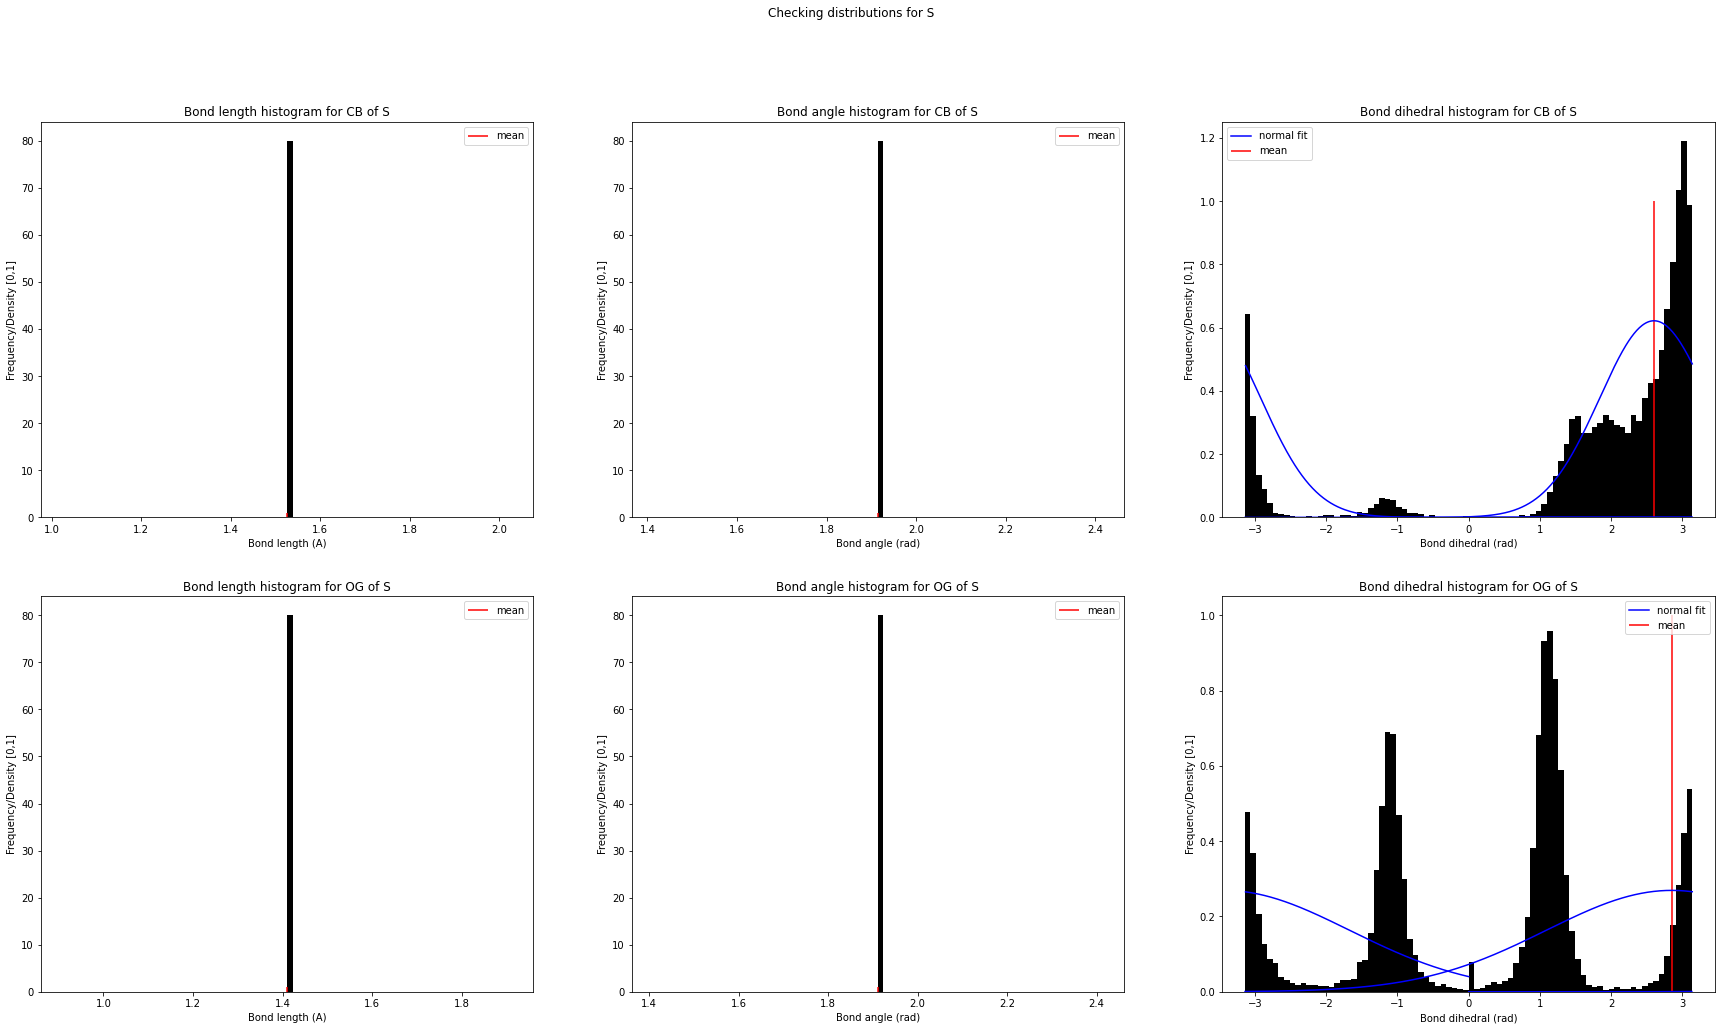

inverted mean needed in T in atom CB
inverted mean needed in T in atom CG2


<Figure size 432x288 with 0 Axes>

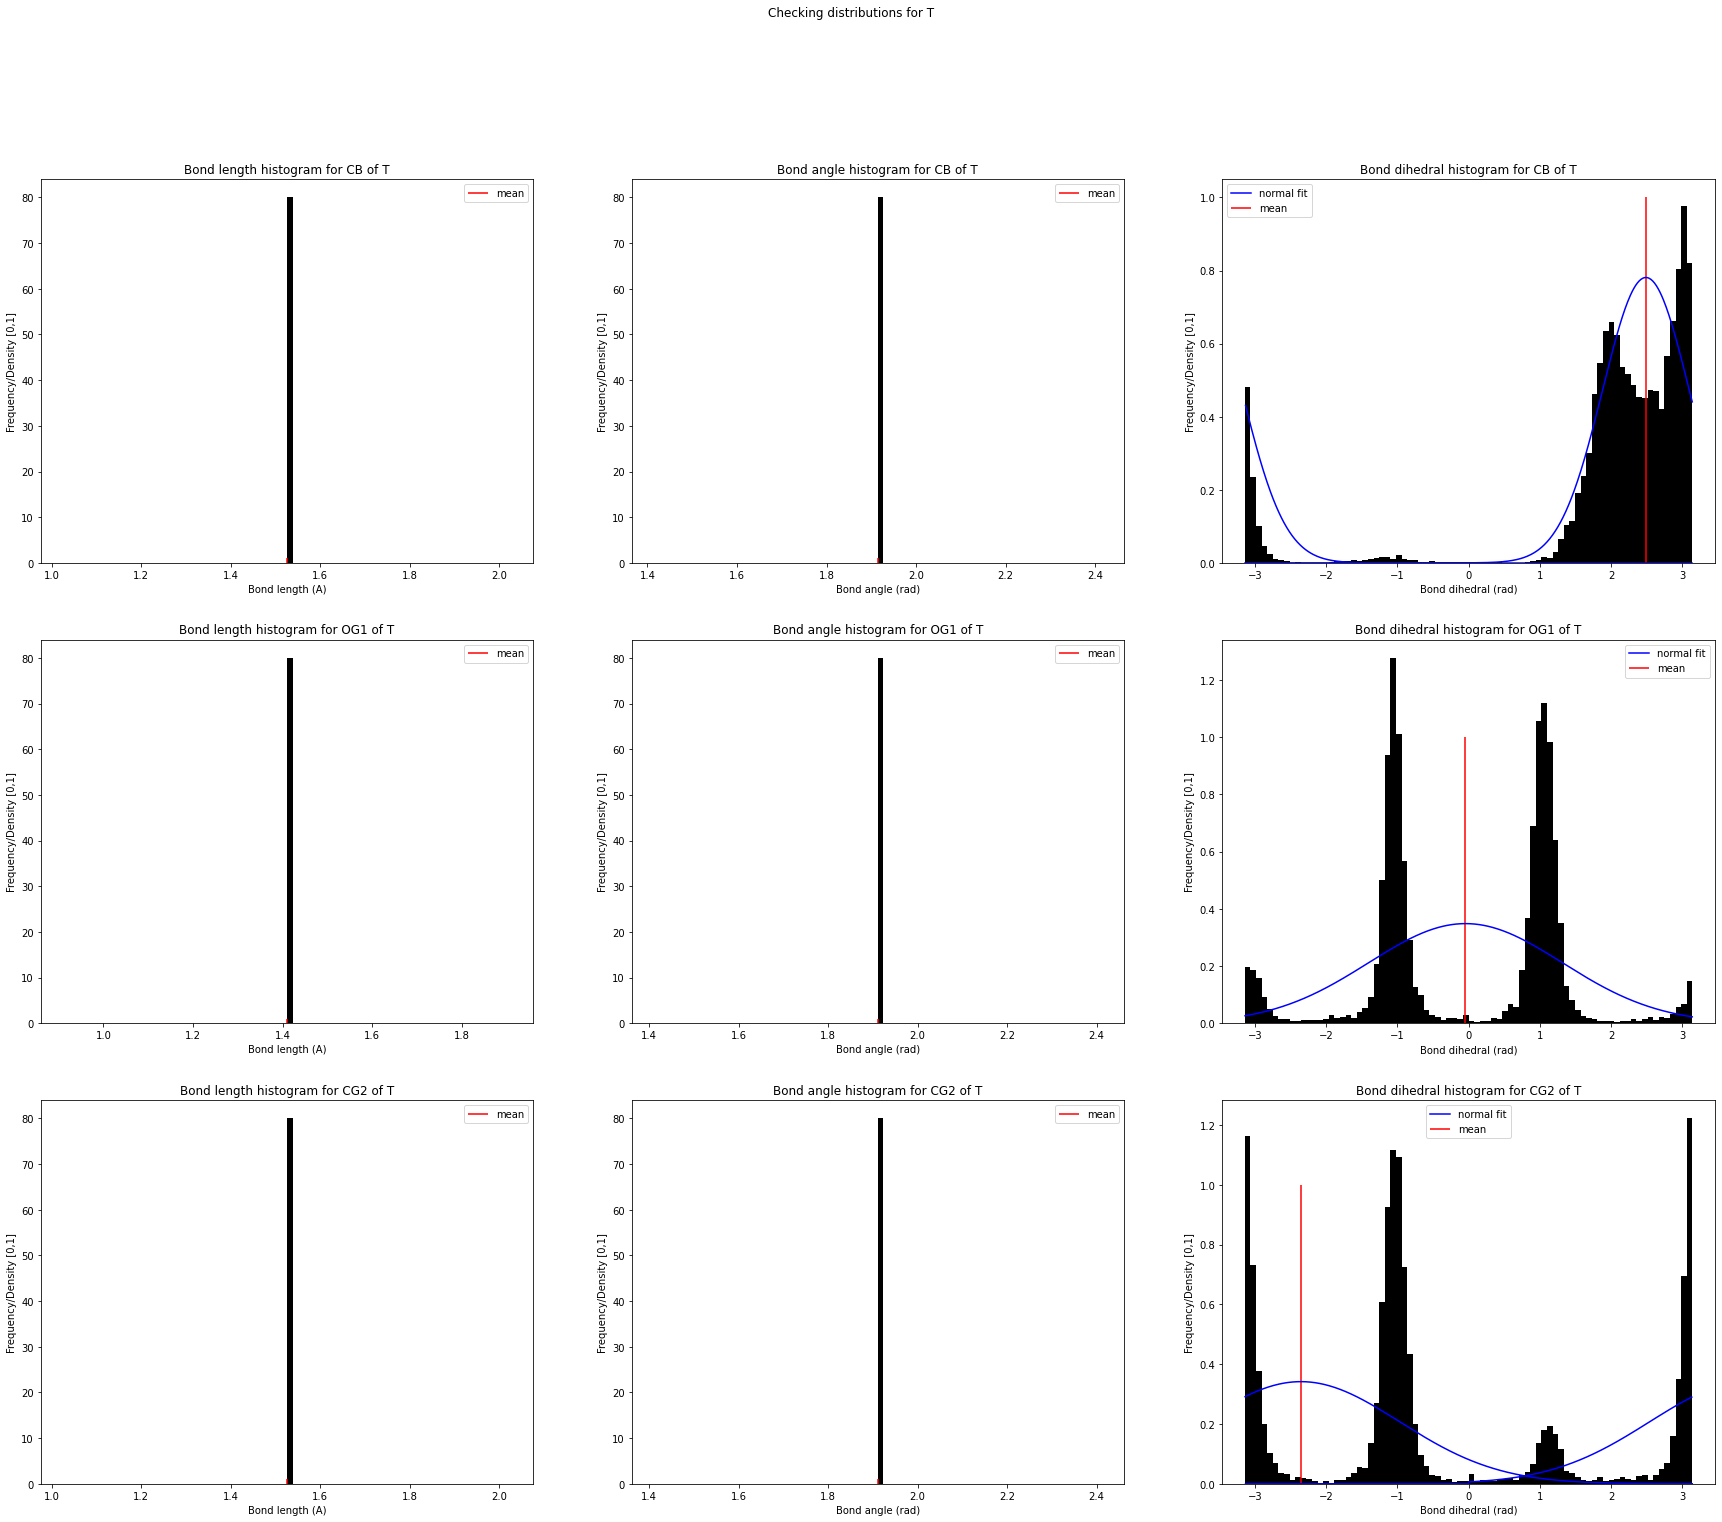

inverted mean needed in W in atom CB
inverted mean needed in W in atom CG


<Figure size 432x288 with 0 Axes>

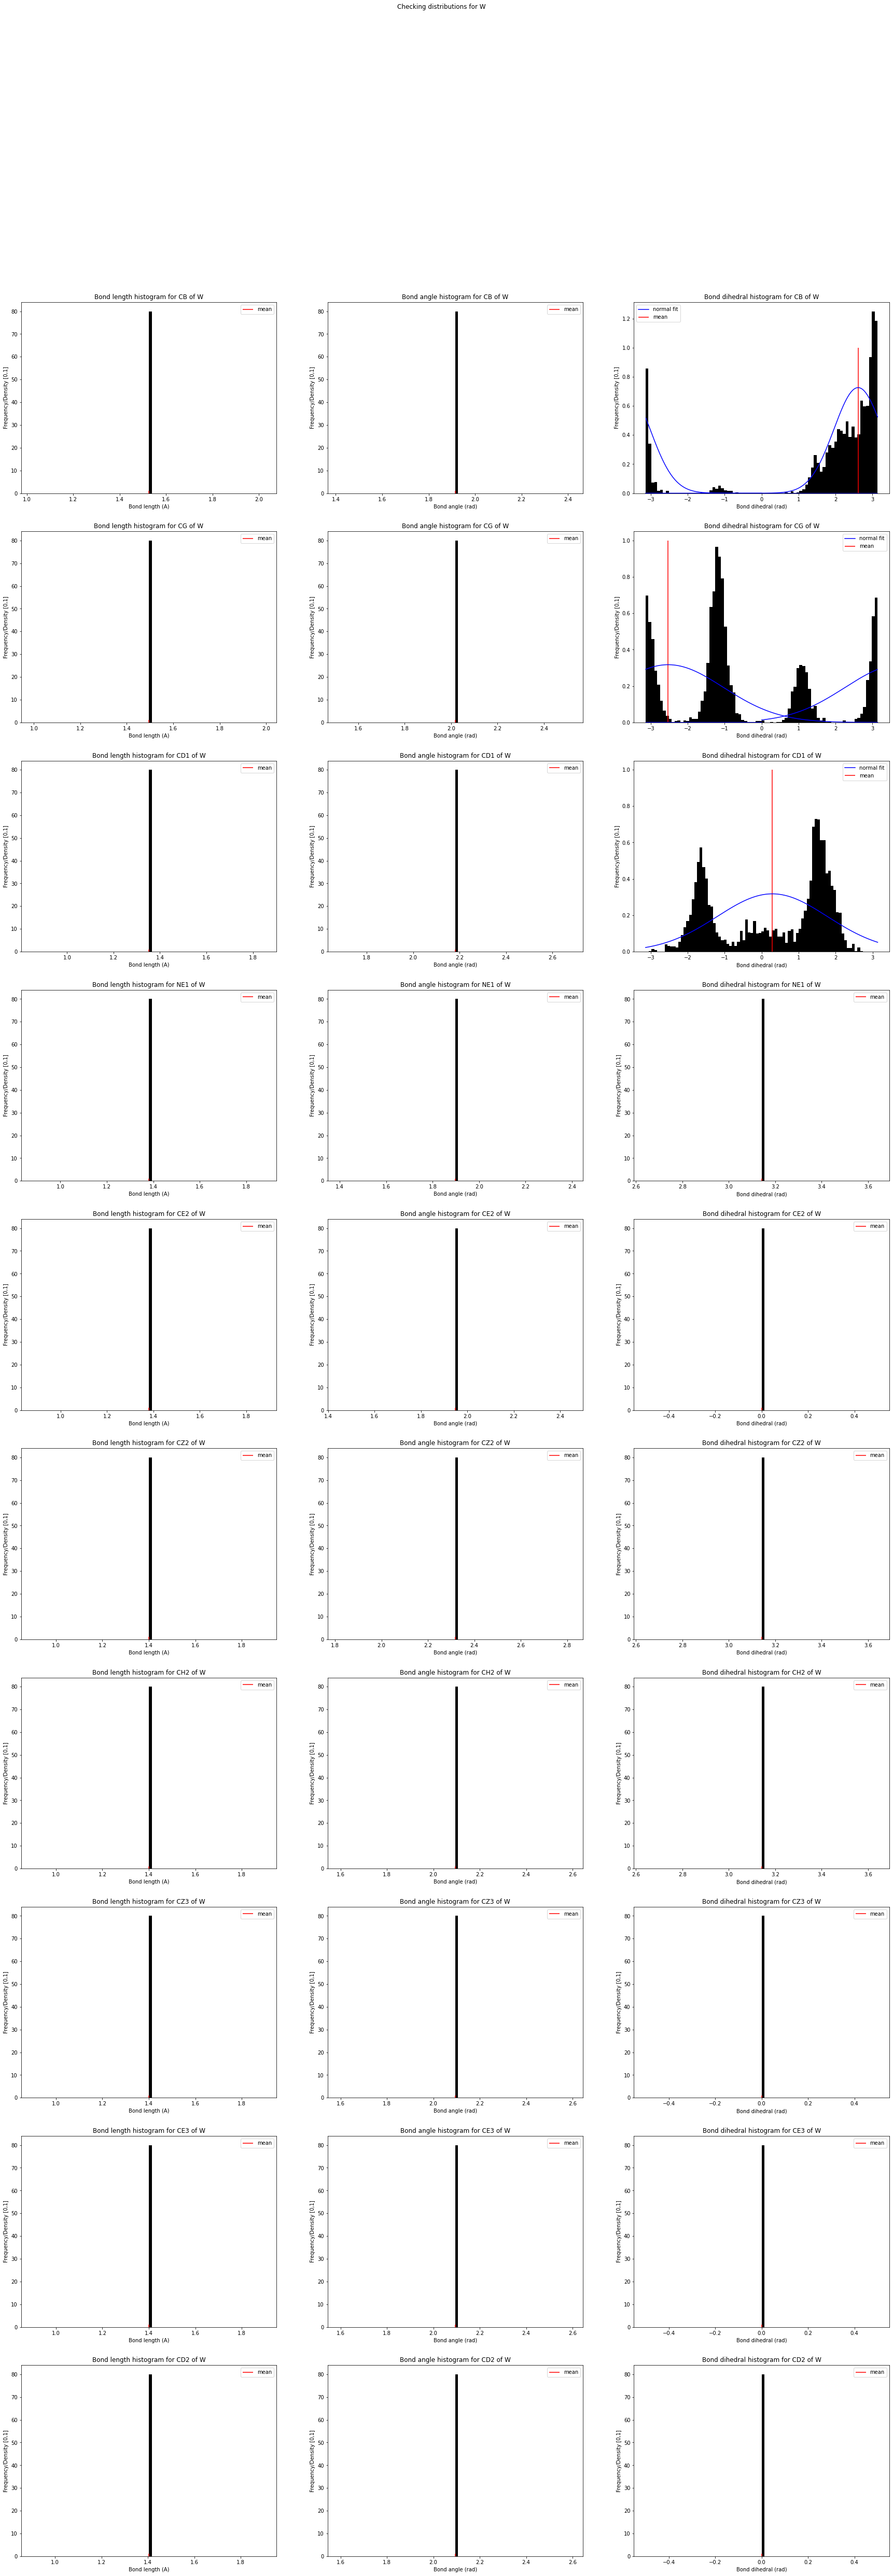

inverted mean needed in Y in atom CB
inverted mean needed in Y in atom CG


<Figure size 432x288 with 0 Axes>

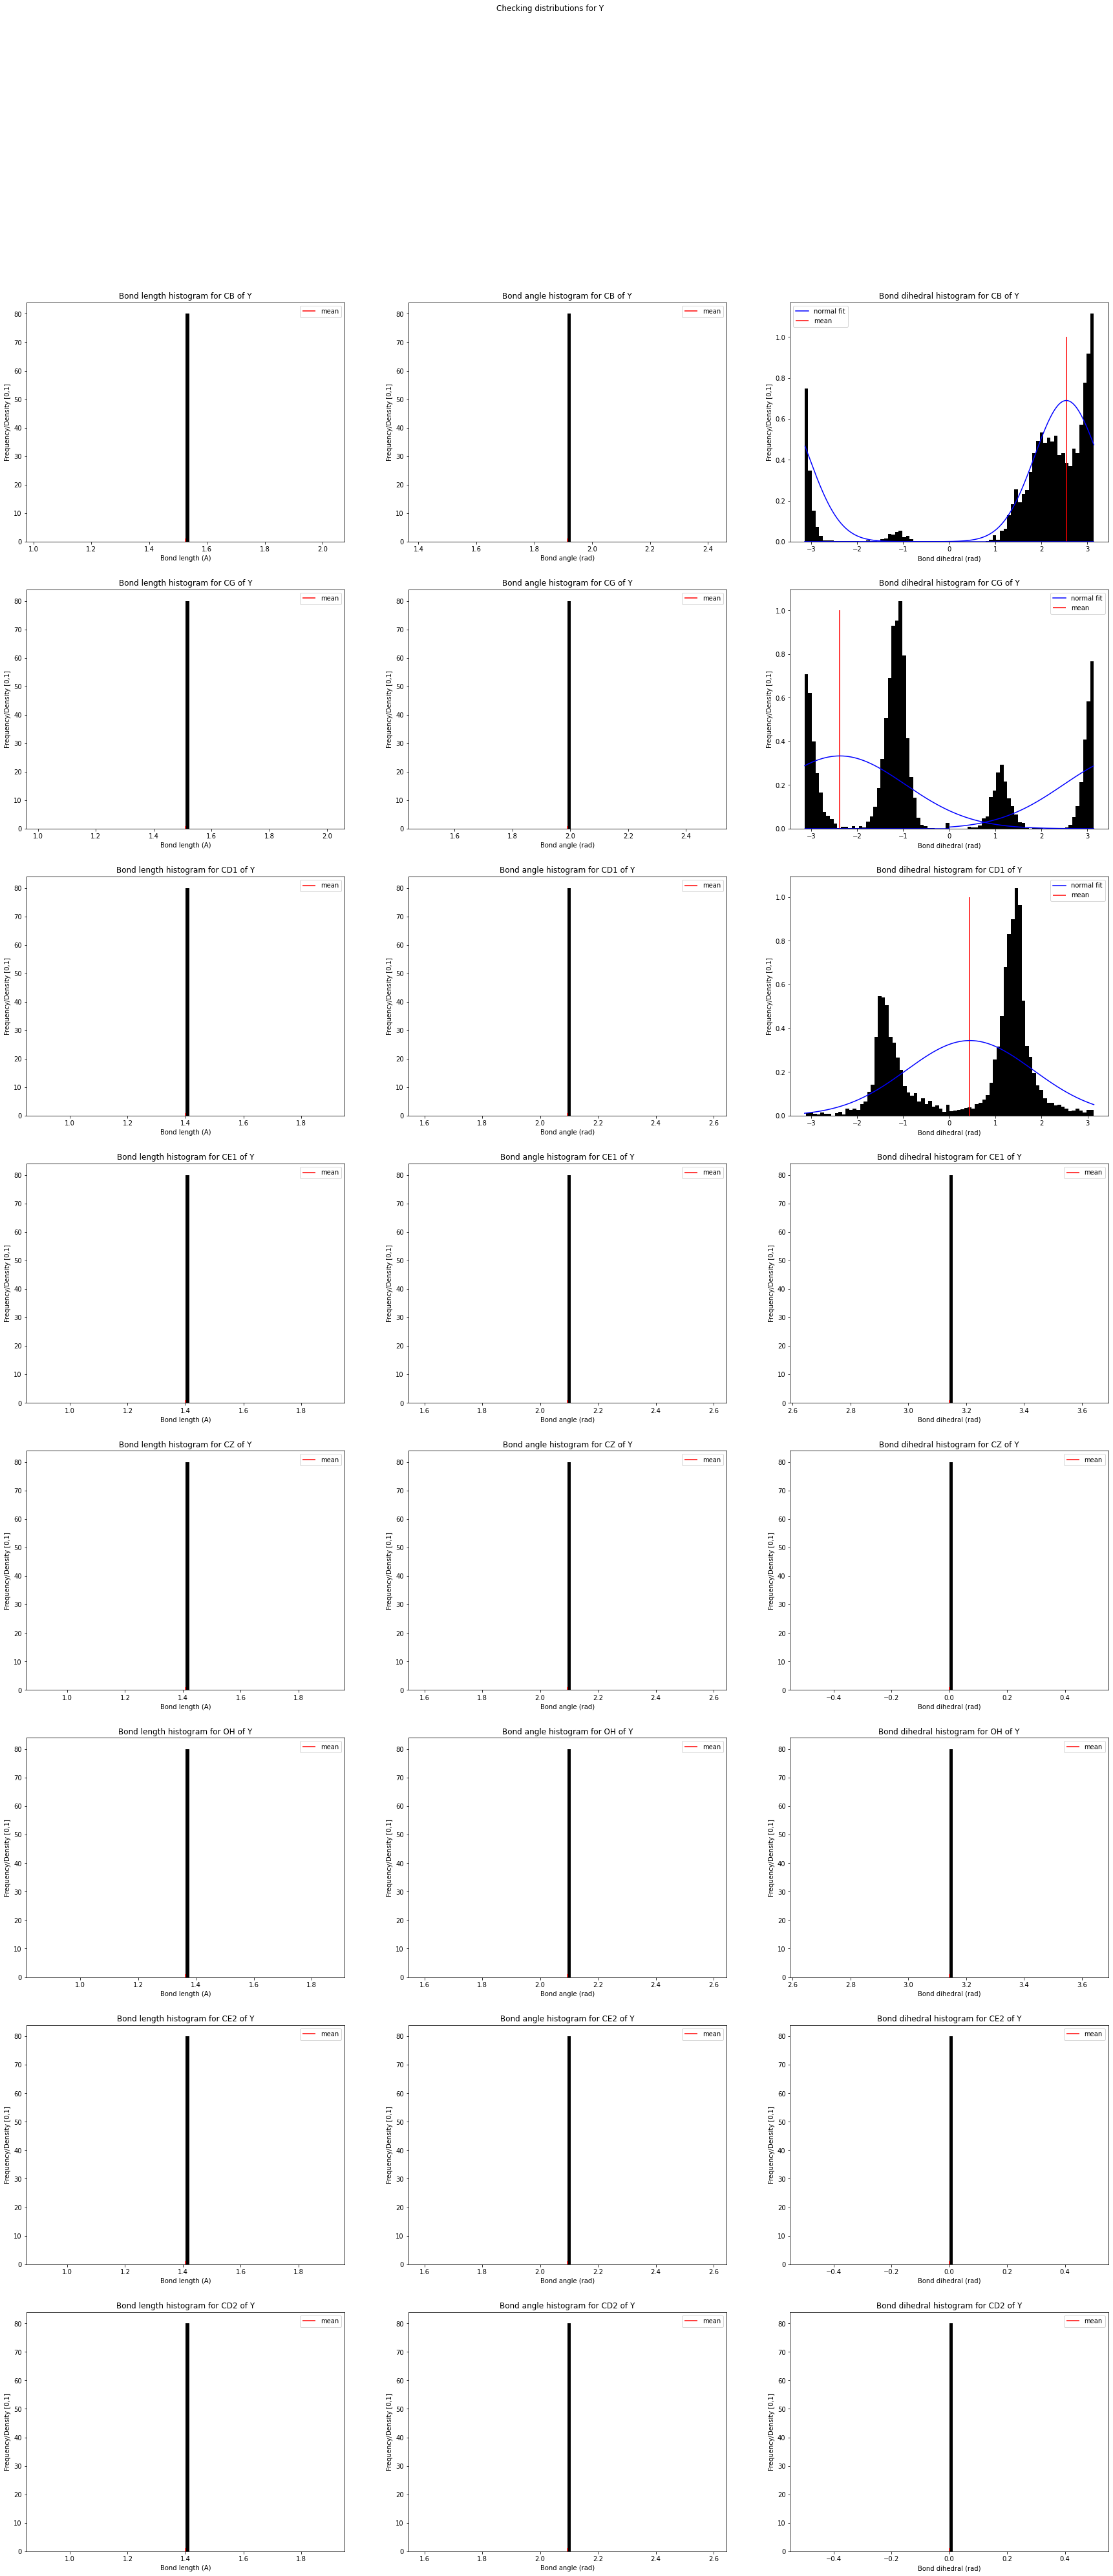

inverted mean needed in V in atom CB
inverted mean needed in V in atom CG1


<Figure size 432x288 with 0 Axes>

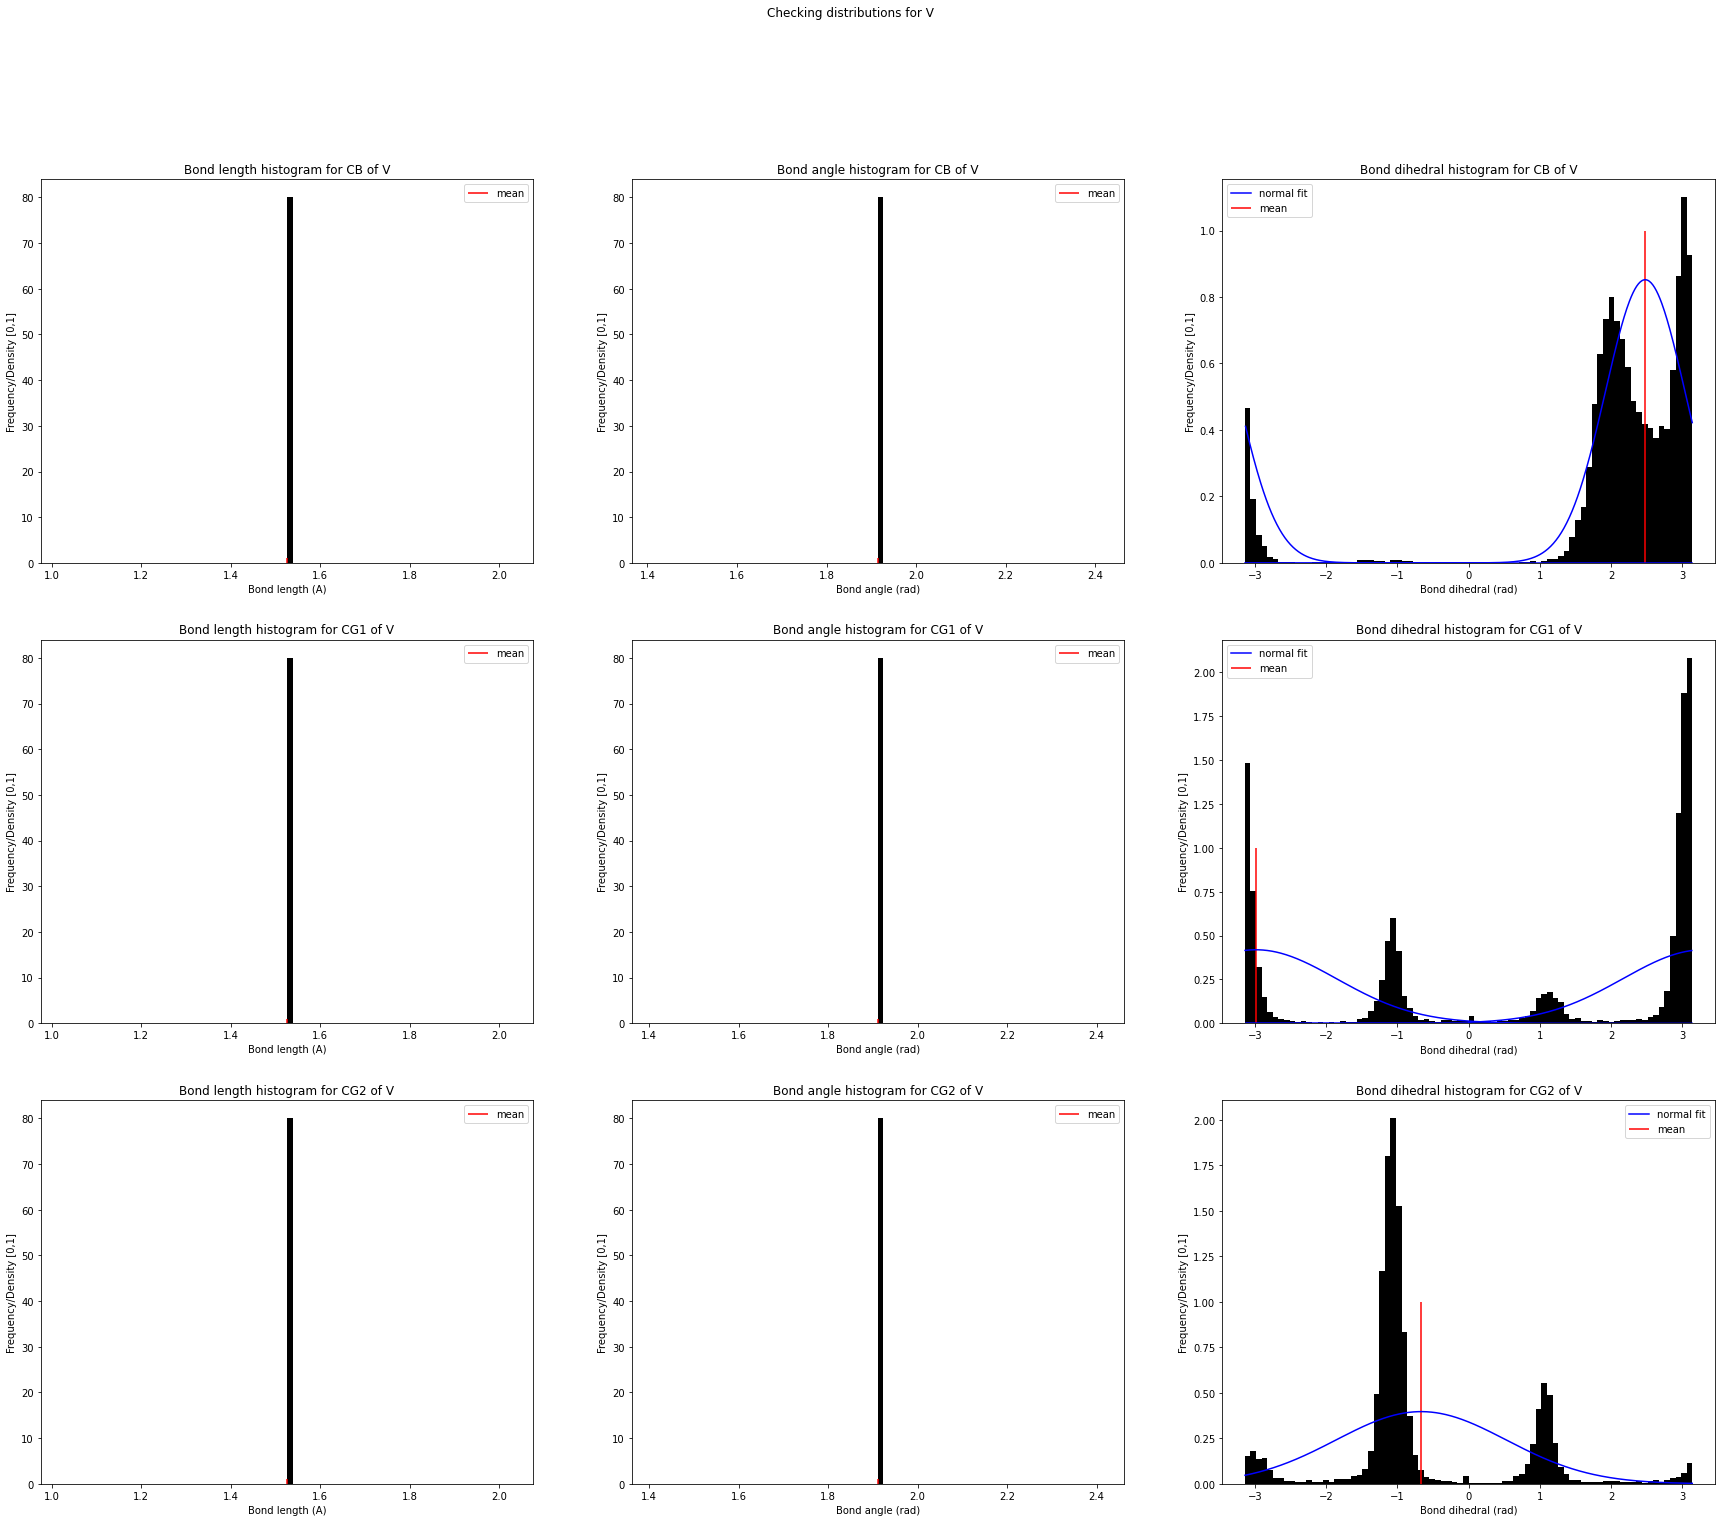

<Figure size 432x288 with 0 Axes>

In [150]:
for AA in SC_BUILD_INFO.keys():
    n_atoms = len(AAS_WHOLE_INFO[AA])

    if n_atoms > 0: 
        plt.figure()
        fig, axs = plt.subplots(n_atoms, 3, figsize=(30, 8*n_atoms))
        for i in range(n_atoms): 
            ax_iter = axs[i] if n_atoms > 1 else axs
            fig.suptitle("Checking distributions for {0}".format(AA))
            atom_name = SC_BUILD_INFO[AA]["atom-names"][i]
            
            # histogram of bond_length
            mu = np.nanmean(AAS_WHOLE_INFO_NUMPY[AA][atom_name]["bond_lens"])
            sigma = np.nanstd(AAS_WHOLE_INFO_NUMPY[AA][atom_name]["bond_lens"])
            some_range = np.linspace( np.min(AAS_WHOLE_INFO_NUMPY[AA][atom_name]["bond_lens"]), 
                                      np.max(AAS_WHOLE_INFO_NUMPY[AA][atom_name]["bond_lens"]), 1000)
            gaussianed_range = gaussian(some_range, mu, sigma)
            ax_iter[0].set_title("Bond length histogram for {0} of {1}".format(atom_name, AA))
            ax_iter[0].hist(AAS_WHOLE_INFO_NUMPY[AA][atom_name]["bond_lens"], density=True, bins=80, color="k")
            ax_iter[0].vlines(mu, 0, 1, colors=["r"], label="mean")
            # only plot gaussian if sigma is acceptable (otherwise not adjusted for histogram scale)
            if sigma > 1e-4:
                ax_iter[0].plot(some_range, gaussianed_range, 'b-', label="normal fit")
            ax_iter[0].legend()
            ax_iter[0].set_xlabel("Bond length (A)")
            ax_iter[0].set_ylabel("Frequency/Density [0,1]")
            # histogram of bond angle
            mu = np.nanmean(AAS_WHOLE_INFO_NUMPY[AA][atom_name]["bond_angs"])
            sigma = np.nanstd(AAS_WHOLE_INFO_NUMPY[AA][atom_name]["bond_angs"])
            some_range = np.linspace( -2*np.pi, 2*np.pi, 1000)
            gaussianed_range = gaussian(some_range, mu, sigma)
            ax_iter[1].set_title("Bond angle histogram for {0} of {1}".format(atom_name, AA))
            ax_iter[1].hist(AAS_WHOLE_INFO_NUMPY[AA][atom_name]["bond_angs"], density=True, bins=80, color="k")
            ax_iter[1].vlines(mu, 0, 1, colors=["r"], label="mean")
            # only plot gaussian if sigma is acceptable (otherwise not adjusted for histogram scale)
            if sigma > 1e-4:
                in_between = np.logical_and(some_range<np.pi, some_range>-np.pi)
                ax_iter[2].plot(some_range[in_between], gaussianed_range[in_between], 'b-', label="normal fit")
            ax_iter[1].legend()
            ax_iter[1].set_xlabel("Bond angle (rad)")
            ax_iter[1].set_ylabel("Frequency/Density [0,1]")
            # histogram of dihedral angle
            
            # due to angle cycles (2pi = 0), calculate the mean that has the lowest std.
            mu = np.nanmean(AAS_WHOLE_INFO_NUMPY[AA][atom_name]["bond_dihedral"])
            sigma = np.nanstd(AAS_WHOLE_INFO_NUMPY[AA][atom_name]["bond_dihedral"])
            inverted = False
            
            copy_data = AAS_WHOLE_INFO_NUMPY[AA][atom_name]["bond_dihedral"].copy()
            copy_data[copy_data<0] += 2*np.pi 
            # only update if std is lower
            if np.nanstd(copy_data) < sigma:
                inverted = True
                mu = np.nanmean(copy_data)
                sigma = np.nanstd(copy_data)
                if mu > np.pi: 
                    mu = -(2*np.pi - mu)
                KB_DICT[AA][atom_name]["bond_dihedral"] = mu
                print("inverted mean needed in", AA, "in atom", atom_name)
            
            
            some_range = np.linspace( -2*np.pi, 2*np.pi, 1000)
            gaussianed_range = gaussian(some_range, mu, sigma)
            ax_iter[2].set_title("Bond dihedral histogram for {0} of {1}".format(atom_name, AA))
            ax_iter[2].hist(AAS_WHOLE_INFO_NUMPY[AA][atom_name]["bond_dihedral"], density=True, bins=80, color="k")
            ax_iter[2].vlines(mu, 0, 1, colors=["r"], label="mean")
            # only plot gaussian if sigma is acceptable (otherwise not adjusted for histogram scale)
            if sigma > 1e-4:
                in_between = np.logical_and(some_range<np.pi, some_range>-np.pi)
                ax_iter[2].plot(some_range[in_between], gaussianed_range[in_between], 'b-', label="normal fit")
                if inverted:
                    # inverted, decompose gaussian
                    upper_mask, lower_mask = some_range>np.pi, some_range<-np.pi
                    ax_iter[2].plot(some_range[upper_mask]-2*np.pi, gaussianed_range[upper_mask], 'b-')
                    ax_iter[2].plot(some_range[lower_mask]+2*np.pi, gaussianed_range[lower_mask], 'b-')
            ax_iter[2].legend()
            ax_iter[2].set_xlabel("Bond dihedral (rad)")
            ax_iter[2].set_ylabel("Frequency/Density [0,1]")
    plt.savefig("xtension/plots/{0}_plot_hists.png".format(AA))
    plt.show()

In [151]:
print("KB_DICT", KB_DICT)

KB_DICT {'A': {'CB': {'bond_lens': 1.5260003, 'bond_angs': 1.9146265, 'bond_dihedral': 2.748366}}, 'R': {'CB': {'bond_lens': 1.5260003, 'bond_angs': 1.9146265, 'bond_dihedral': 2.6976738}, 'CG': {'bond_lens': 1.5260003, 'bond_angs': 1.9111352, 'bond_dihedral': -2.296891752873556}, 'CD': {'bond_lens': 1.5260003, 'bond_angs': 1.9111352, 'bond_dihedral': -3.0688698927508753}, 'NE': {'bond_lens': 1.463, 'bond_angs': 1.9408059, 'bond_dihedral': -3.1065035502063196}, 'CZ': {'bond_lens': 1.34, 'bond_angs': 2.1502457, 'bond_dihedral': -3.1146112124072474}, 'NH1': {'bond_lens': 1.34, 'bond_angs': 2.094395, 'bond_dihedral': 0.024268176}, 'NH2': {'bond_lens': 1.34, 'bond_angs': 2.094395, 'bond_dihedral': -3.1173246}}, 'N': {'CB': {'bond_lens': 1.5260003, 'bond_angs': 1.9146265, 'bond_dihedral': 2.8416245}, 'CG': {'bond_lens': 1.5219998, 'bond_angs': 1.9390607, 'bond_dihedral': -2.35341984430422}, 'OD1': {'bond_lens': 1.229, 'bond_angs': 2.101376, 'bond_dihedral': -0.087414205}, 'ND2': {'bond_lens

### Textual Data

In [70]:
for AA in AAS_WHOLE_INFO_NUMPY:
    print("AA: ", AA)
    # print({atom: {k: np.nanmean(v) for k,v in v_atom.items()} for atom,v_atom in AAS_WHOLE_INFO_NUMPY[AA].items()})
    for atom,v_atom in AAS_WHOLE_INFO_NUMPY[AA].items(): 
        print(atom, {k: (round(np.nanmean(v), 4),
                         round(np.nanstd(v), 4)) for k,v in v_atom.items()})
    print("\n\n=======\n\n")

AA:  A
CB {'bond_lens': (1.526, 0.0), 'bond_angs': (1.9146, 0.0), 'bond_dihedral': (1.7652, 2.0473)}




AA:  R
CB {'bond_lens': (1.526, 0.0), 'bond_angs': (1.9146, 0.0), 'bond_dihedral': (1.7202, 1.9534)}
CG {'bond_lens': (1.526, 0.0), 'bond_angs': (1.9111, 0.0), 'bond_dihedral': (-0.8055, 1.8219)}
CD {'bond_lens': (1.526, 0.0), 'bond_angs': (1.9111, 0.0), 'bond_dihedral': (-0.0571, 2.6142)}
NE {'bond_lens': (1.463, 0.0), 'bond_angs': (1.9408, 0.0), 'bond_dihedral': (-0.0674, 2.2391)}
CZ {'bond_lens': (1.34, 0.0), 'bond_angs': (2.1502, 0.0), 'bond_dihedral': (-0.0304, 2.2811)}
NH1 {'bond_lens': (1.34, 0.0), 'bond_angs': (2.0944, 0.0), 'bond_dihedral': (0.0243, 0.9029)}
NH2 {'bond_lens': (1.34, 0.0), 'bond_angs': (2.0944, 0.0), 'bond_dihedral': (-3.1173, 0.9029)}




AA:  N
CB {'bond_lens': (1.526, 0.0), 'bond_angs': (1.9146, 0.0), 'bond_dihedral': (1.6064, 1.7957)}
CG {'bond_lens': (1.522, 0.0), 'bond_angs': (1.9391, 0.0), 'bond_dihedral': (-0.9772, 1.6286)}
OD1 {'bond_lens': (1.229, 

In [ ]:
# torsion (to elongate oxygen) torsion: 
a = []
for i in range(len(prot_scaffolds)):
    a.extend(prot_scaffolds[i]["angles_mask"][-1, :, 3].tolist())
plt.hist(a)
print("the mean torsion for a protein is: ", np.mean(a))